# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from joblib import load
from typing import Tuple, List, Dict
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = 20
pd.options.display.max_columns = 10

# Project constants
PROCESSED_DATA_PATH = './data/'
IMAGE_PATH = './images/'

# Part 2: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [2]:
def load_data_from_pickle_file(filename: str, file_path: str = PROCESSED_DATA_PATH) -> pd.DataFrame:
    '''
    INPUT:
    filename - (string) the file name of the pickle file
    file_path - (string) the path name where the pickle file is held
    
    OUTPUT:
    data - (pandas dataframe) the dataframe object to load into a pickle file
    '''
    
    full_path = file_path + filename
    
    try:
        df_processed_data = load(full_path)
    except:
        print('Unable to load pickle file {}'.format(full_path))
        return pd.DataFrame()
    else:
        print('Loaded pickle file {}'.format(full_path))
        return df_processed_data

In [3]:
# Load the processed data of the general population from a pickle file
df_cleaned = load_data_from_pickle_file(filename='processed_data.pk')
df_cleaned.head()

Loaded pickle file ./data/processed_data.pk


,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,...,ZABEOTYP_1,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_Other,ZABEOTYP_nan
1,0.0,11.0,0.0,2.0,0.0,...,False,False,False,True,False
2,17.0,10.0,0.0,1.0,0.0,...,False,False,False,True,False
3,13.0,1.0,0.0,0.0,0.0,...,False,True,False,False,False
4,20.0,3.0,0.0,4.0,0.0,...,False,False,True,False,False
5,10.0,5.0,0.0,1.0,0.0,...,False,False,True,False,False


## Step 1: Setting up the Pipeline

First of all, I'm going to build a [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to encapsulate all the operations to be perfomed in that part into the suitable components. These components will hold customized classes of [RobusScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)(i.e., Normalizer), [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.fit) (i.e., Reducer), and [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) (i.e., Cluster). The first two relates to the feature transformation (i.e., Normalizer and Reducer); whereas, the third component (i.e., Cluster) corresponds to the unsupervised ML.

Any of these components requires to define the following 4 methods:
- init. Method setting up the component
- fit. Method fitting the component with the required input matrix or dataframe depending on the case
- transform. Method applying the fitted component to the required input matrix or dataframe depending on the case
- inverse_transform. Method undoing the transformation applied to the input matrix or dataframe depending on the case

Additionally, the Reducer and Cluster components will have an extra method to set the value of a specific attribute and re-fit the component. 

### Step 1.1: Component class for Feature Scaling
Before applying dimensionality reduction to the data, feature scaling is required so that the principal component vectors are not influenced by the natural differences in scale for features. To this end, a scaler component needs to be set up to normalize the features between 0-1 range. Sklearn library gives [a wide range of scalers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#plot-all-scaling-robust-scaler-section) to be used but the robust scaler seems to be the most robust to deal with outliers.

In [4]:
class Normalizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        """
        Setting up a robust scaler object for later use
        """
        self.rs = RobustScaler()
        self.df_normalized = None
        
    def fit(self, X: pd.DataFrame, y=None) -> RobustScaler:
        """
        Fitting the robust scaler object with the input dataframe X
        """
        self.columns = X.columns
        self.rs.fit(X)
        return self
        
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Normalizing the input dataframe X with the fitted robust scaler object
        """
        self.df_normalized = pd.DataFrame(self.rs.transform(X), columns=X.columns, index=X.index)
        return self.df_normalized

    
    def inverse_transform(self, X: np.array) -> np.array:
        """
        Denormalizing the numpy array X with the fitted robust scaler object
        """
        return np.round(self.rs.inverse_transform(X))

### Step 1.2: Component class for Dimensionality Reduction

Dimensionality reduction will be applied to the scaled data using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). This technique applies principal component analysis by finding the vectors of maximal variance in the data. To start with, I am not going to set the maximum number of features (i.e., all components will be computed), so as to see the general trend in variability.

In [5]:
class Reducer(BaseEstimator, TransformerMixin):
    def __init__(self):
        """
        Setting up a PCA object for later use
        """
        self.pca = PCA(random_state=42)
        self.X_pca = None
        self.df_reducer = None
      
    def fit(self, X: pd.DataFrame, y=None):
        """
        Fitting the PCA object with the normalized dataframe X
        """
        self.pca.fit(X)
        
    def transform(self, X: pd.DataFrame) -> np.array:
        """
        Applying PCA to the normalized dataframe X
        """
        self.X_pca = self.pca.transform(X)
        self.df_reducer = pd.DataFrame(data=self.pca.components_, columns=X.columns)
        return self.X_pca
    
    def inverse_transform(self, X=None) -> np.array:
        """
        Going back to the original space
        """       
        return np.dot(self.X_pca, self.pca.components_)
    
    def set_fit_transform(self, n_components: int, X: pd.DataFrame) -> np.array:
        """
        Set the n_clusters attribute of KMeans object to the given value, refit and transform it
        """
        self.pca.n_components = n_components
        self.fit(X)
        return self.transform(X)

### Step 1.3: Component class for clustering

[KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) clustering will be applied to the PCA-transformed data, and used the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

In [6]:
class Cluster(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.kmeans = KMeans(random_state=42)
    
    def fit(self, X: np.array, y=None):
        """
        Fitting the kmeans with the reduced array X
        """
        self.kmeans.fit(X)
        
    def transform(self, X: np.array) -> np.array:
        """
        Do nothing, just return the input array
        """
        return X
    
    def inverse_transform(self, X: np.array):
        """
        Do nothing
        """      
        pass
    
    def predict(self, X: np.array) -> np.array:
        """
        Predicting the cluster id's for each row (customer)
        """
        return self.kmeans.predict(X)
    
    def set_fit_predict(self, n_clusters: int, X: np.array) -> np.array:
        """
        Set the n_clusters attribute of KMeans object to the given value, refit it and make predictions
        """
        self.kmeans.n_clusters = n_clusters
        self.fit(X)
        return self.predict(X)

### Step 1.4: Creating the Pipeline with the above defined components
The full pipeline will be built by creating specific objects from the above defined classes to later applied the fit, transform and predict methods at once.

In [7]:
# Building the full pipeline holding objects of the above defined classes
full_pl = Pipeline([("normalizer", Normalizer()), 
                    ("reducer", Reducer()), 
                    ("cluster", Cluster())])

## Step 2: Fitting the Pipeline for feature transformation
### Step 2.1: Apply feature scaling and preliminary dimensionality reduction

The customized RobustScaler and PCA components will be fitted and transfomerd by calling the pipeline fit method. I am not fitting at this step the customized K-Means component as later I am going to re-fit the PCA with fewer number of components.

In [8]:
full_pl[0:2].fit(df_cleaned)

Pipeline(steps=[('normalizer', Normalizer()), ('reducer', Reducer())])

In [9]:
def test_normalizer(df: pd.DataFrame) -> None:
    """
    This method checks that the values of all columns are within 0 and 1 range
    
    INPUT:
        df (dataframe) - Normalized dataset to be checked 
    
    OUTPUT: None
    """
    
    for col in df.columns:
        assert df[col].between(0, 1, inclusive='both').any(), "Some values are not within 0, 1 range in column {}".format(col)
    print("All values are within the 0, 1 range")
    
def test_reducer(n_components: int, explained_variance_ratio: np.array) -> None:
    """
    This method checks that the amount of reduced features corresponds to the desired amount
    
    INPUT:
        n_components - number of elements to be expected to have the PCA-transformed dataset
        explained_variance_ratio (numpy array) - Array with the explained variance ratio of each component in df
    
    OUTPUT: None
    """
    
    assert len(explained_variance_ratio) == n_components, "Number of features mismatch: {} != {}".format(
           len(explained_variance_ratio), n_components)
    print("Number of features match")

In [10]:
# Checking that the values of all columns are within 0 and 1
df_norm = full_pl['normalizer'].df_normalized
test_normalizer(df=df_norm)

# Ensuring that the amount of reduced features corresponds to the desired amount
test_reducer(n_components=df_cleaned.shape[1], explained_variance_ratio=full_pl['reducer'].pca.explained_variance_ratio_)

All values are within the 0, 1 range
Number of features match


### Step 2.2: Improve Dimensionality Reduction

The idea of this step is to minimize as much as possible the number of transformed features by the PCA. To this end, I will check out the ratio of variance explained by each principal component as well as the cumulative variance explained by plotting the cumulative and sequential values using matplotlib's [plot](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on the findings, I will select the value for that number explaining the greatest portion of the variance, which will be retained for the clustering. Having made that choice, I will re-fit the customized PCA component to perform the decided-on transformation.

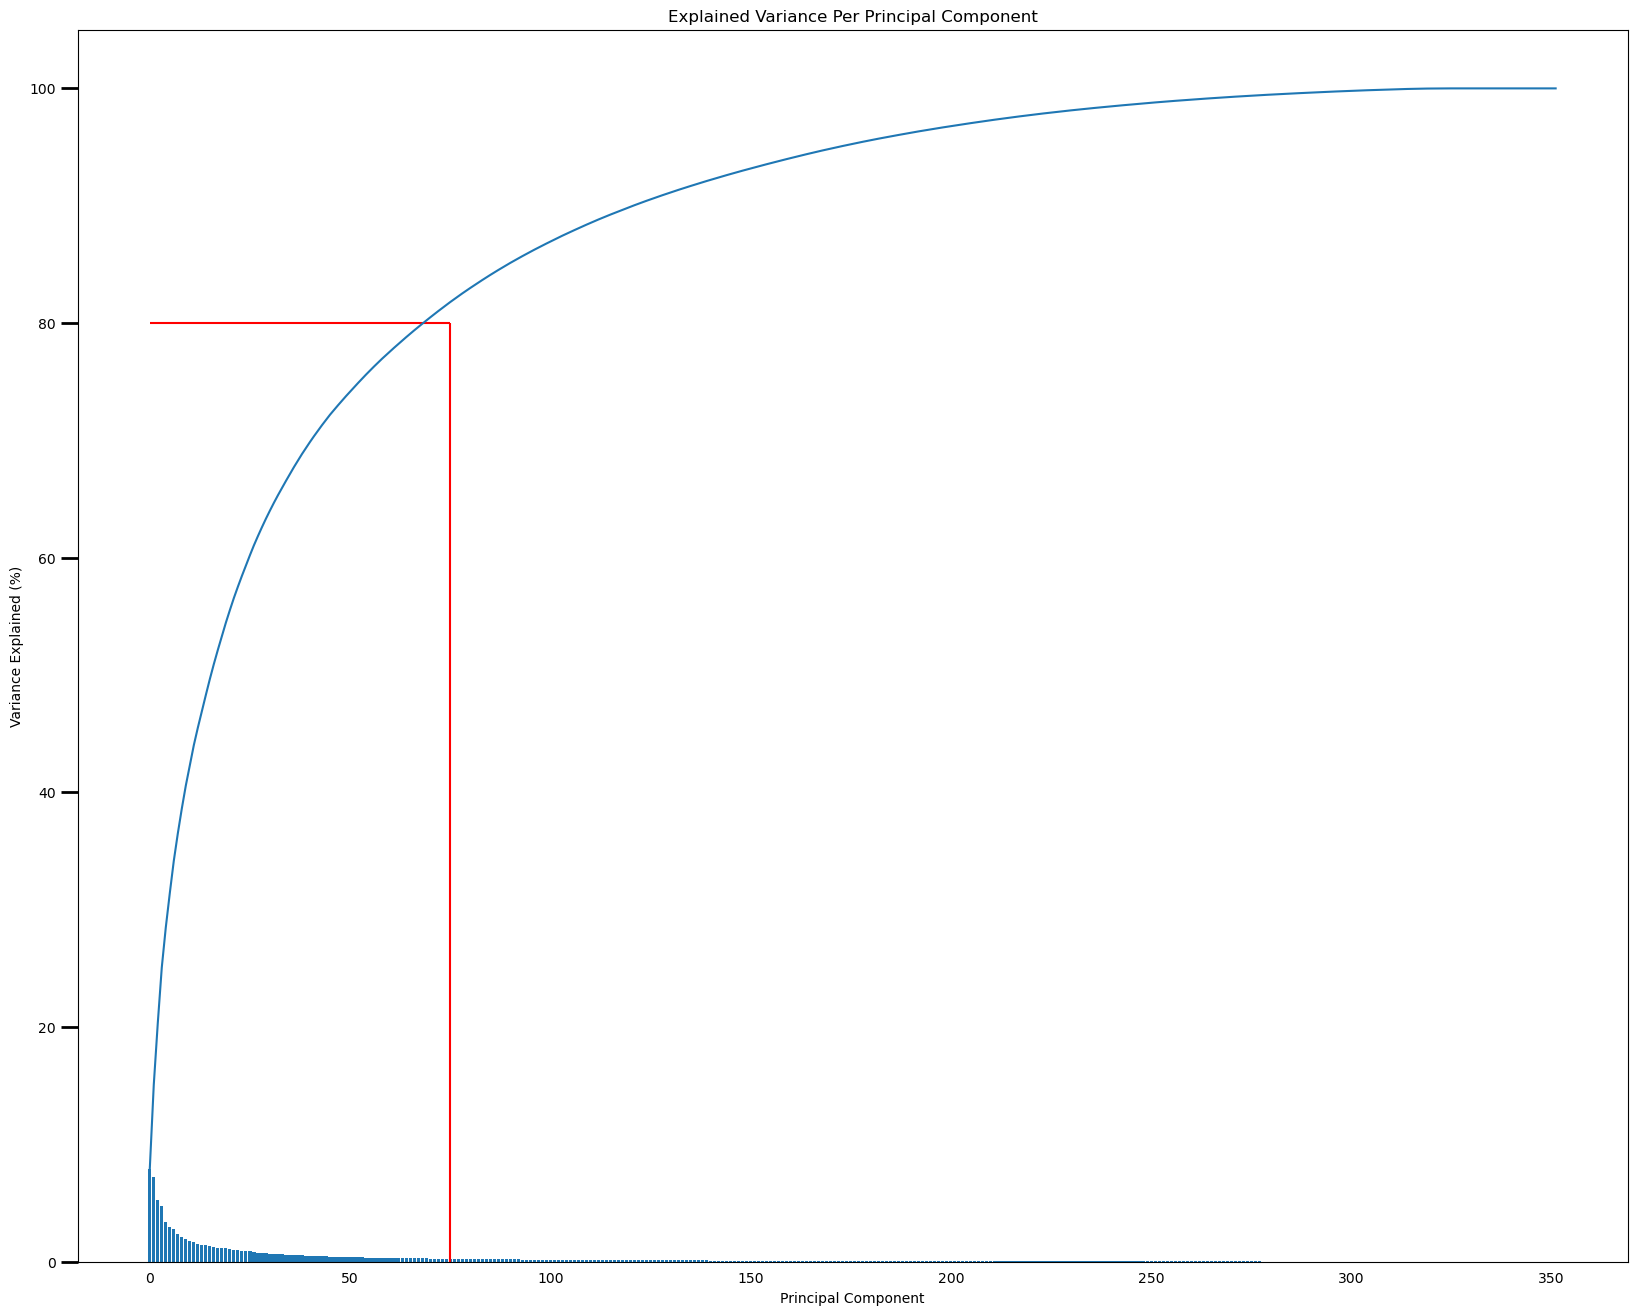

In [11]:
# Investigating the variance accounted for by each principal component.
def scree_plot(pca: PCA, n_components: int) -> None:
    '''
    Creates a plot showing the cumulative and sequential variance associated with the principal components 
    
    INPUT: pca - An instance of PCA in scikit learn
           n_components - number of selected features to be transformed
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = 100*pca.explained_variance_ratio_
 
    fig = plt.figure(figsize=(20,16))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    plt.hlines(y=80, xmin=0, xmax=n_components, color='red', linestyles='-', zorder=1)
    plt.vlines(x=n_components, ymin=0, ymax=80, color='red', linestyles='-', zorder=2)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    fig.savefig(IMAGE_PATH + 'scree_plot.png', format='png')

n_components = 75
scree_plot(full_pl['reducer'].pca, n_components=n_components)

We can see that around **80% of the variance** is explained with only **75** out of 350 **components**.

In [12]:
# Re-apply PCA to the data while selecting for number of components to retain.
X_pca = full_pl['reducer'].set_fit_transform(n_components, df_norm)
df_reducer = full_pl['reducer'].df_reducer.copy()

In [13]:
# Ensuring that the amount of reduced features corresponds to the desired amount
test_reducer(n_components=n_components, explained_variance_ratio=full_pl['reducer'].pca.explained_variance_ratio_)

Number of features match


### Step 2.3: Interpret Principal Components

Having had the transformed principal components, I will check out the weight of each feature on the first three components to interpret them in the following manner. Each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

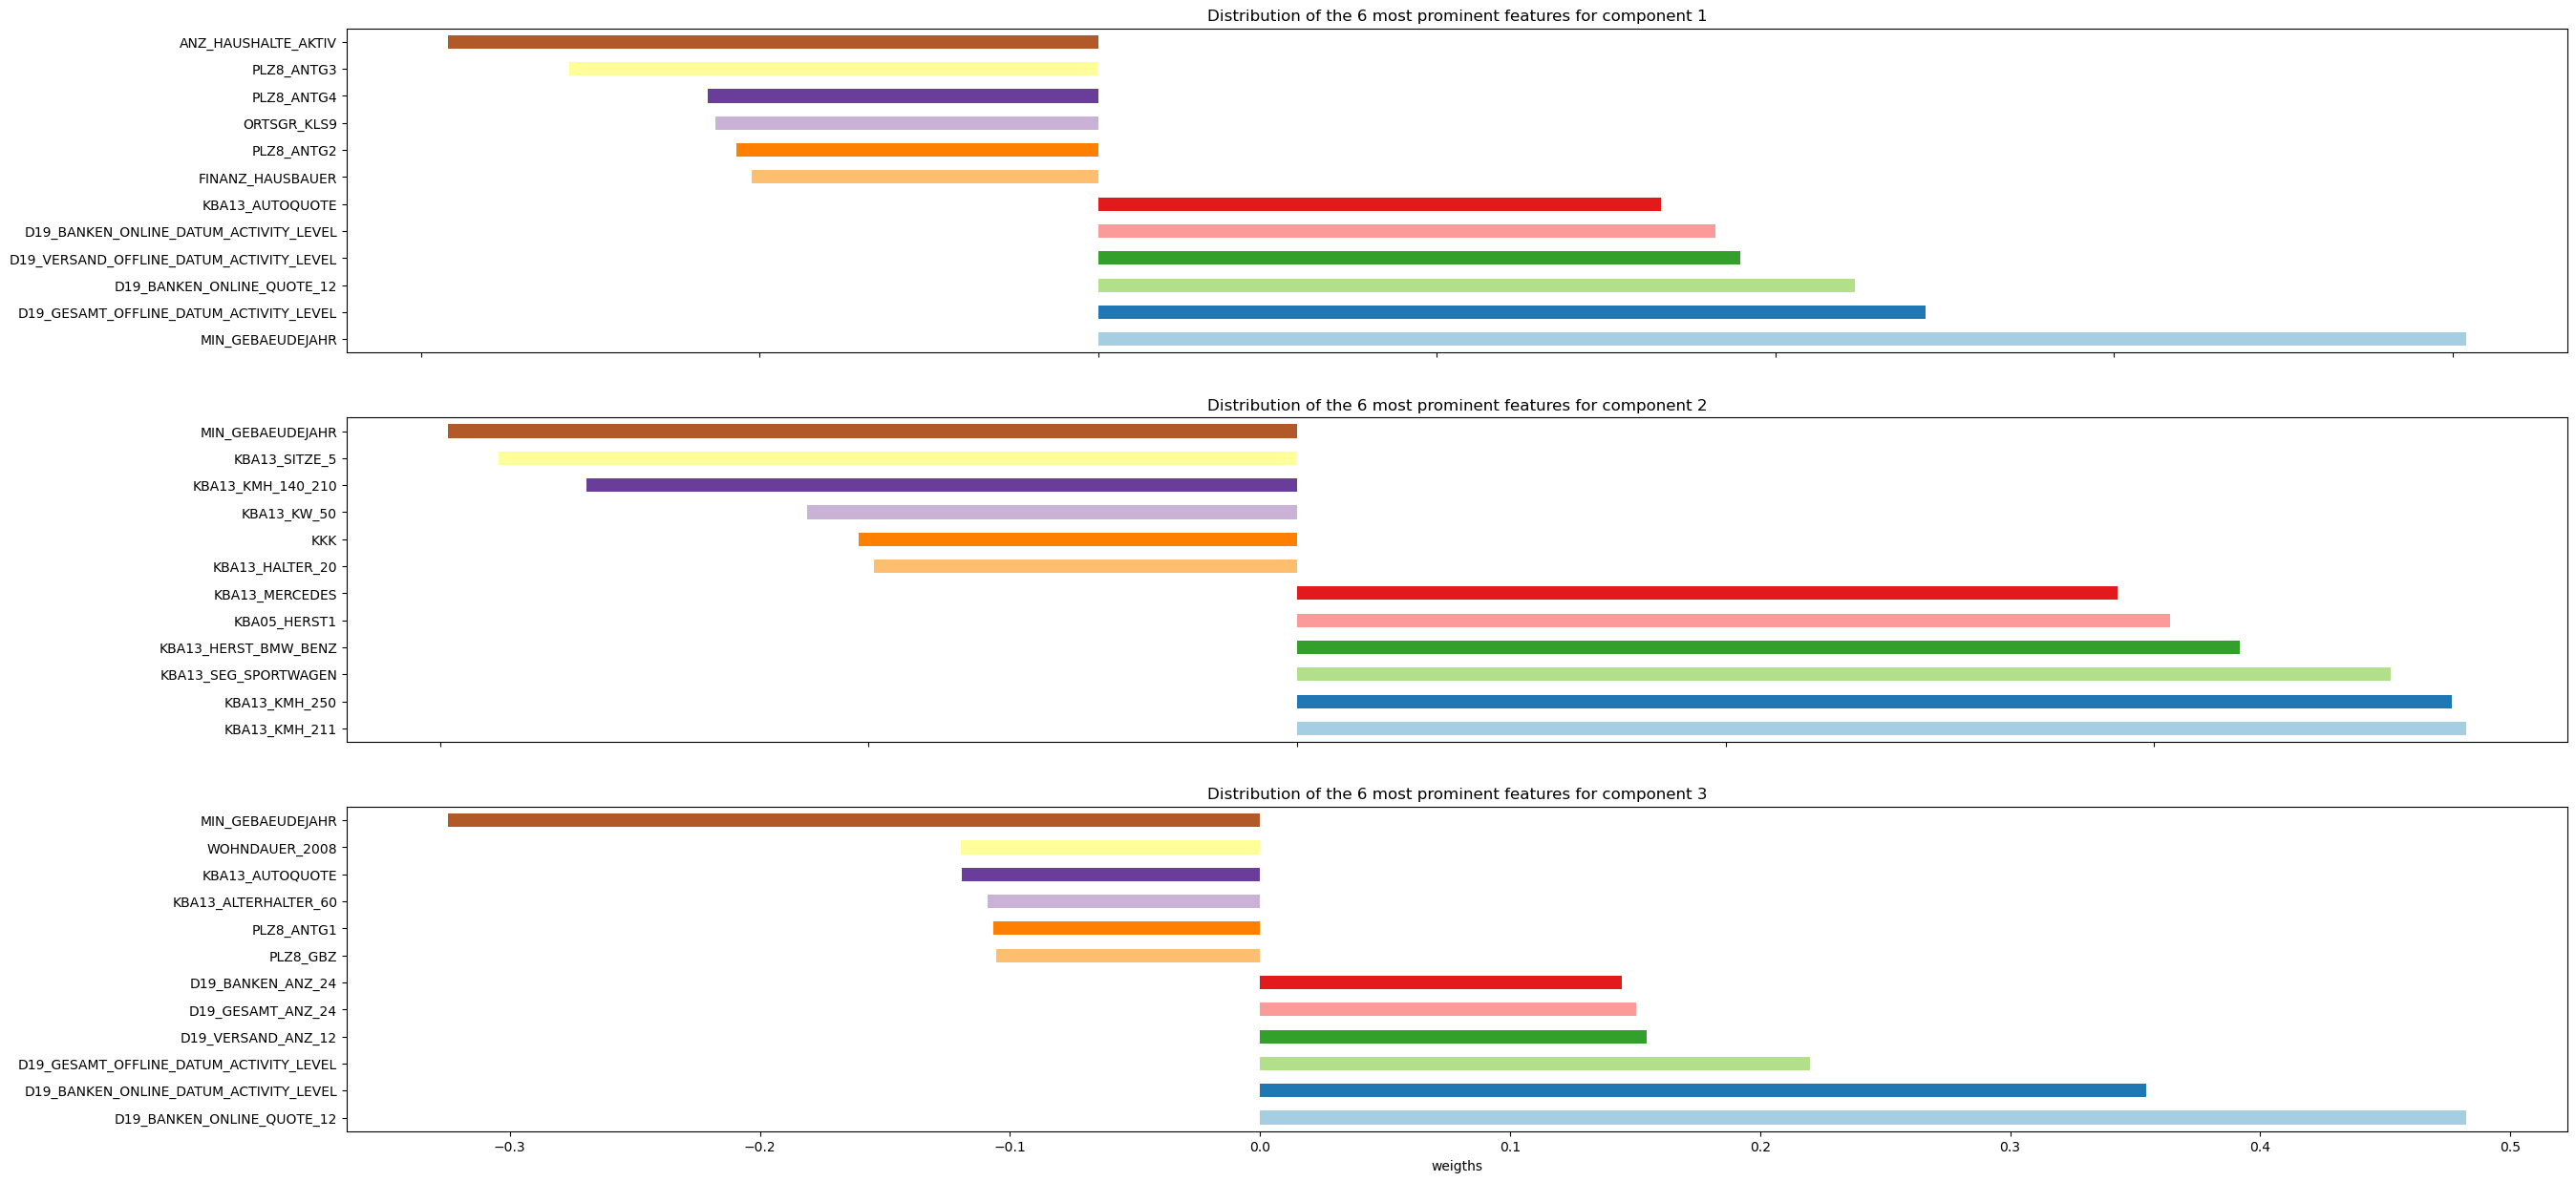

In [14]:
# Map weights for the first three principal components to corresponding feature names and then print the linked values, 
# sorted by weight.
def plot_first_n_features_per_m_components(df: pd.DataFrame, n_disp_feat: int = 6, n_components: int = 3) -> list:
    '''
    This method plots the first n positive and n negative feature weights sorted in a decreasing fashion, along with their 
    related feature names for m given component
    
    INPUT: df          - DataFrame whose rows represent the components and columns the features
           component   - Integer with the position of the component in df
           n_disp_feat - Number of features to display (default 6)
            
    OUTPUT:
            list wit the names of the features related to the weights 
    '''

    fig = plt.figure()
    axis = fig.subplots(3, 1)
    for component in range(0, n_components):
        
        sorted_weights = df.iloc[component].sort_values(ascending = False)
        selected_weights = pd.concat([sorted_weights[:n_disp_feat], sorted_weights[-n_disp_feat:]], axis=0)
    
        selected_weights.plot(ax=axis[component],
                              kind='barh', 
                              rot=0, 
                              sharex=True,
                              figsize=(30, 15), 
                              title='Distribution of the ' + str(n_disp_feat) + ' most prominent features for component '  + str(component+1), 
                              xlabel='weigths', 
                              color=plt.cm.Paired(np.arange(selected_weights.shape[0])))
        
    fig.savefig(IMAGE_PATH + 'interpret_PCs.png', format='png')
        
plot_first_n_features_per_m_components(df=df_reducer)

We can observe from the three horizontal bar graphs that,

- MIN_GEBAEUDEJAHR is an outstanding weigthed feature in all the components, but in different directions. For the first component, it is positively weighted; whereas for the second and third components, it is negatively weighted.

- In the first component, we have two important negatively weighted features, ANZ_HAUSHALTE_AKTIVE and PLZ8_ANTG8. So, if MIN_GEBAEUDEJAHR is increased, ANZ_HAUSHALTE_AKTIVE and PLZ8_ANTG8 will be decreased, and viceversa.

- In the second component, we also have KBA13_SITZE_5 as another important negatively negatively weighted feature; whereas, for the positively weighted ones, KBA13_KMH_211, KBA13_KMH_250 and KBA13_SEG_SPORTWAGEN are outstanding. So if either MIN_GEBAEUDEJAHR or KBA13_SITZE_5  are increased, KBA13_KMH_211, KBA13_KMH_250 and KBA13_SEG_SPORTWAGEN will be decreased, and viceversa.

- For the third component, we can see one outstanding positively weighted feature, D19_BANKEN_ONLINE_QUOTE_12. So, if MIN_GEBAEUDEJAHR is increased, D19_BANKEN_ONLINE_QUOTE_12 will be decreased, and viceversa.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

Now, it's time to see how the data clusters in the principal components space. In this substep, I will apply the customized k-means component to the PCA transformed data and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep. Then, I will compute the average difference from each point to its assigned cluster's center using the `.score()` method. 

These two steps will be performed for different number of clusters so as to see how the average distance decreases with the increase of clusters. Each additional cluster provides a net benefit decreasing as the number of clusters increases, so once this beneft is small enough, the optimal number of clusters is reached. 

Because of the large size of the dataset, it can take a long time for getting the optimal number. The more clusters to fit, the longer the algorithm will take. Consequently, I will be using a faster version of the kmeans method, MiniBatchKMeans.

Having determined the optimal number of clusters to use, I will fit the customized kmeans component with that number to perform the clustering operation.

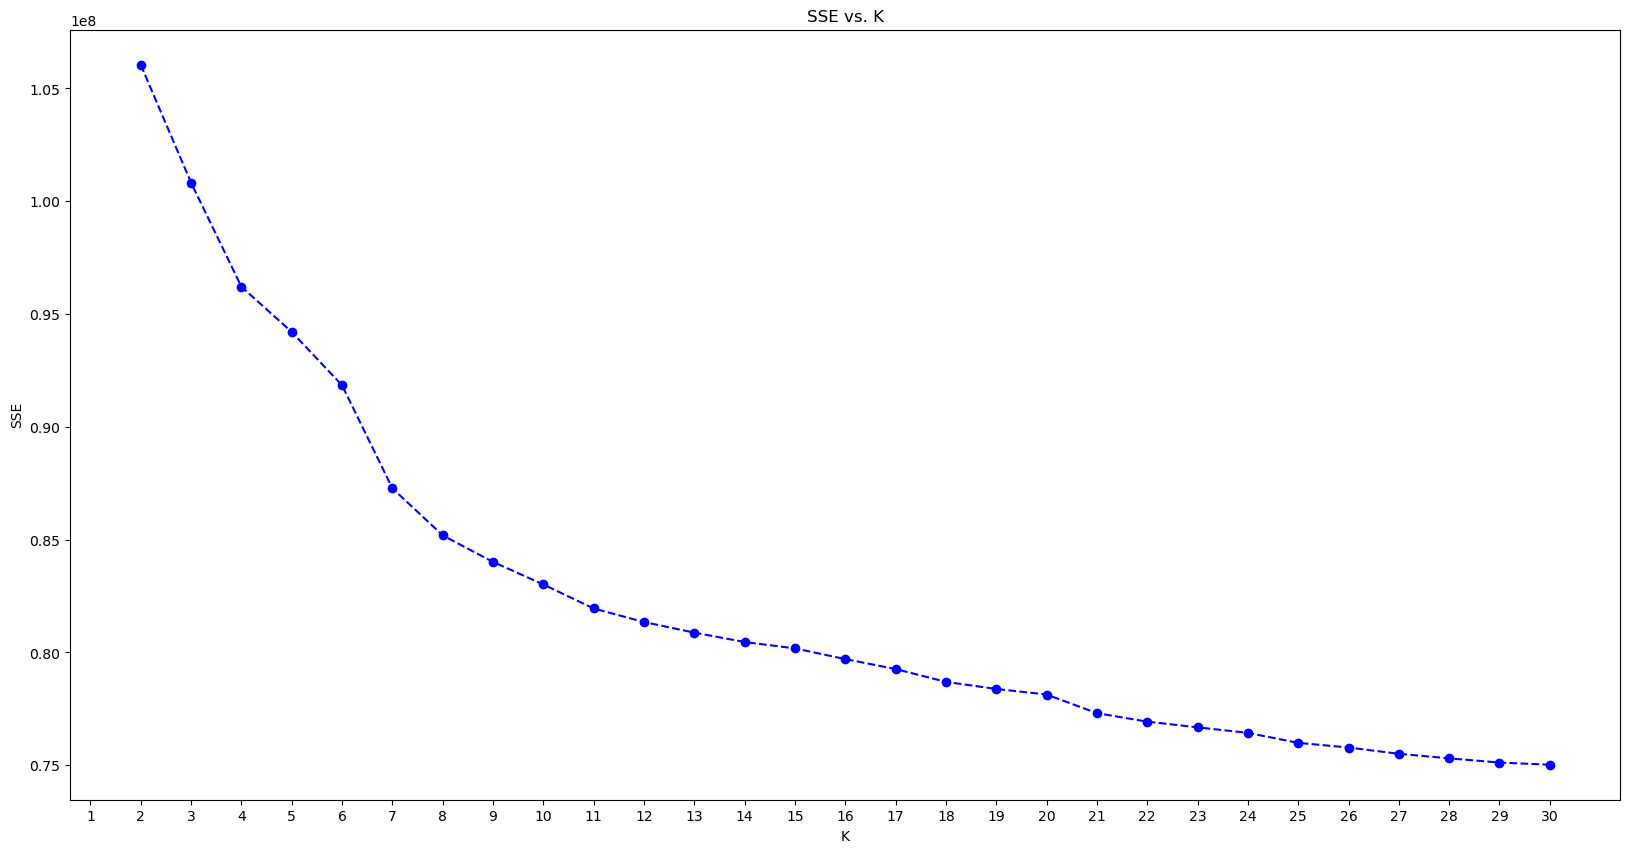

In [15]:
def investigate_best_k_value(data: np.array, max_k: int = 30):
    '''
    This method computes the SSE metric within a given range of k-values to fit the MiniKmeans object and plots them in order 
    to determine the best k-value (where an elbow can be seen in the plotted trace)
    INPUT:
        data (numpy array) - the dataset you want to fit minikmeans to comming from the PCA output object 
    
    OUTPUT: None
    '''

    scores = []
    n_clusters_tests = range(2, max_k + 1) 
    for n_clusters in n_clusters_tests:
        
        # Creating a faster version of k-means clustering using one additional cluster
        kmeans = MiniBatchKMeans(random_state=42, n_clusters=n_clusters)
        
        # Re-fitting the kmeans object
        model = kmeans.fit(data)
    
        # Computing the average within-cluster distances.
        score = np.abs(model.score(data))
        scores.append(score)
    
    # Investigating the change in within-cluster distance across number of clusters.
    fig = plt.figure(figsize=(20,10))
    plt.plot(n_clusters_tests, scores, linestyle='--', marker='o', color='b')
    plt.xticks(range(1, max_k + 1))
    plt.xlabel('K')
    plt.ylabel('SSE')
    plt.title('SSE vs. K')
    fig.savefig(IMAGE_PATH + 'investigate_best_k_value.png', format='png')
    
investigate_best_k_value(data=X_pca)

In [16]:
# Fitting the k-means object of the pipeline with the selected number of clusters and obtaining cluster predictions for the 
# general population demographics data.
opt_k = 19
gen_labels = full_pl['cluster'].set_fit_predict(opt_k, X_pca)

In [17]:
def test_cluster(*, k: int, labels: np.array) -> None:
    """
    This method checks that the labels are held within the expected 0 and k-1 range 
    
    INPUT:
        k (int >=2) - number of clusters
        labels (array) - Array holding the labels
    
    OUTPUT: None
    """
    
    good_clustered = np.where(np.logical_and(labels >= 0, labels < opt_k))
    assert len(good_clustered[0]) == len(labels), "Not all clients are correctly clustered"
    print('All labels are correctly clustered')

In [18]:
# Checking that the general labels are within the desired range
test_cluster(k=opt_k, labels=gen_labels)

All labels are correctly clustered


### Step 3.2: Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. I won't be re-fitting all of the pipeline components to the customer data. Instead, I am going to use the fits from the general population to normalize, reduce, and cluster the customer data. With the output of this step and to finalize this part, I will interpret how the general population fits apply to the customer data.

In [19]:
# Load the processed data of the customers from a pickle file
df_customers_cleaned = load_data_from_pickle_file(filename='processed_customers_data.pk')

Loaded pickle file ./data/processed_customers_data.pk


In [20]:
# Applying Robust Scaler and PCA transformations as well as predicting the customers clusters using k-means in one go 
cust_labels = full_pl.predict(df_customers_cleaned)

In [21]:
# Checking that the values of all columns are within 0 and 1
test_normalizer(df=full_pl['normalizer'].df_normalized)

# Ensuring that the amount of reduced features corresponds to the desired amount
test_reducer(n_components=n_components, explained_variance_ratio=full_pl['reducer'].pca.explained_variance_ratio_)

# Checking that the customer labels are within the desired range
test_cluster(k=opt_k, labels=cust_labels)

All values are within the 0, 1 range
Number of features match
All labels are correctly clustered


### Step 3.3: Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final step, I will compare the two cluster distributions to see where the strongest customer base for the company is.

If we consider the proportion of persons in each cluster of the general vs customers populations, and think the company's customer base is to be universal, then the cluster assignment proportions should be fairly similar between the two. 

If, however, there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

In [22]:
def calc_proportions(labels: np.array) -> List[float]:
    '''
    This function computes the ratios of each cluster given the list with the ids of the clusters where each element belongs to
    
    INPUT:
        labels - A list with the ids of the clusters where each element is attacthed to 
    OUTPUT:
        proportions - An ordered list with the ratios of each cluster elements with respect to the total  
    '''
    
    n_elements = len(labels)
    amount_per_cluster = Counter(labels)
    amount_per_cluster_sorted = sorted(amount_per_cluster.items())
    proportions = [100*(qty/n_elements) for cluster, qty in amount_per_cluster_sorted]
    return proportions

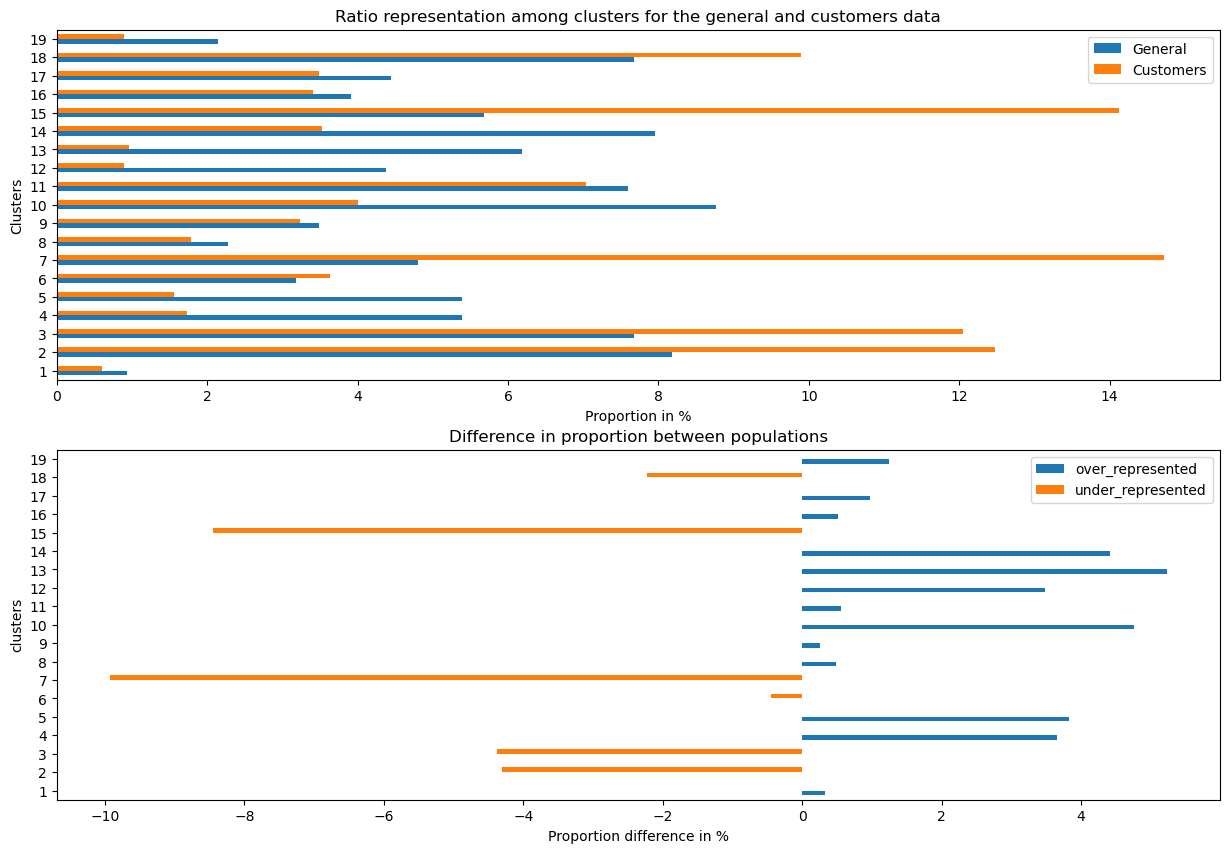

In [23]:
# Compare the proportion of data in each cluster for the customer data to the proportion of data in each cluster for the 
# general population.

def clusters_comparison(gen_labels: np.array, cust_labels: np.array, opt_k: int) -> None:
    '''
    This function helps to compare the proportion in each cluster for the general against customers population. 
    The first plot draws 
     
    INPUT:
        gen_labels (numpy array)  - An array with the ids of the clusters related to the general population
        cust_labels (numpy array) - An array with the ids of the clusters related to the customers population
        opt_k (integer)           - Optimal number of clusters
        
    OUTPUT: None  
    '''
    
    # Counting the proportions in each dataset
    gen_props = calc_proportions(labels = gen_labels)
    cust_props = calc_proportions(labels = cust_labels)

    # Turning into a dataframe
    df_props = pd.DataFrame({'General': gen_props, 'Customers': cust_props}, index=range(1, opt_k + 1))

    fig = plt.figure()
    axis = fig.subplots(2,1)

    # Displaying the bar graph
    df_props.plot(ax=axis[0],
                  kind='barh', 
                  figsize=(30,15),
                  xlabel='Proportion in %',
                  ylabel='Clusters', 
                  title='Ratio representation among clusters for the general and customers data')

    diff_props = df_props['General'] - df_props['Customers']
    
    df_rep = pd.DataFrame()
    df_rep['over_represented'] = diff_props.apply(lambda x: x if x > 0 else 0)
    df_rep['under_represented'] = diff_props.apply(lambda x: x if x < 0 else 0)
    
    axis = df_rep.plot(ax=axis[1],
                       kind='barh',
                       figsize=(15,10),
                       xlabel='Proportion difference in %', 
                       ylabel='clusters', 
                       title='Difference in proportion between populations')

    fig.savefig(IMAGE_PATH + 'Clusters_comparison.png', format='png')
    
clusters_comparison(gen_labels, cust_labels, opt_k)

By looking at the above figure, we can see that customers of clusters 4, 5, 12, 13, 19 are overrepresented, whereas the ones held in clusters 2, 3, 7, 15 are underrepresented. The rest of clusters contains customers that are similar-represented. 

Now, I am wondering what kinds of people are part of the most overrepresented and underepresented clusters. To answer them, I am going to use [the following approach](https://knowledge.udacity.com/questions/906309). First, I will bring the customers' features related to the given cluster back to their original space. Second, I will plot the associated principal components in a bar graph, and picked up the 6 most outstanding features: three for the positive weights, and three for the negative ones. Third, I will plot the distribution of each feature in a separate graph. From these graphs, I will infer the type of customers by looking at the highest bar(s) and their value meaning in the DIAS Attributes - Values 2017.xlsx file. Steps 2-3 will be repeated as many times as the number of customers within clusters times the three main principal components to be analyzed. These steps will also be encoded in a function.

In [24]:
# Applying all the transformation steps of the built pipeline back to get the data into its original format
# Note: We do not pass the Xt matrix as the cluster component does not have an inverse_transform method, instead the 
#       output pca-transformed matrix of the reducer transform method has been used, which was saved when applied that method.
X_orig = full_pl.inverse_transform(Xt=None)

In [25]:
def analyze_under_or_over_rep_cust_clusters(df_components: pd.DataFrame, df_cleaned: pd.DataFrame, 
                                            X_orig: np.array, 
                                            cluster_id: int, labels: np.array, 
                                            n_components: int=3, n_disp_feat: int=6) -> None:
    '''
    This function helps to analyze the customers that are either overpreseneted or underrepresented in a given cluster by 
    plotting the distribution of the first n_disp_feat features for each component as well as the distribution of the 3 most 
    important features. 
    
    INPUT: 
        df_components (pandas dataframe) - Transformed-pca dataset 
        df_cleaned (pandas dataframe)    - Dataset of the customers 
        X_orig (numpy array)   - Matrix of n_customers x n_features
        labels (numpy array)   - Matrix of n_clusters ids for each customer
        cluster_id (integer)   - Id of the cluster under study
        n_components (integer) - Number of cluster components to display (default 3)
        n_disp_feat            - Number of features of each component to display (default 6)
    
    OUTPUT: None
    '''
    
    for component in range(0, n_components):
        
        # Creating a new figure object
        fig = plt.figure(num = component, figsize = (75, 75))
        
        # Splitting the figure into two subfigures vertically
        subfigs = fig.subfigures(2, 1)
    
        # In the top subfigure, a bar graph is plotted to show the distribution of the n_disp_feat prominent features for the 
        # given component
        sorted_weights = df_components.iloc[component].sort_values(ascending = False)
        selected_weights = pd.concat([sorted_weights[:n_disp_feat], sorted_weights[-n_disp_feat:]], axis=0)
        selected_weights.plot(ax=subfigs[0].subplots(1, 1),
                              kind='barh', 
                              rot=0, 
                              title='Distribution of the ' + str(n_disp_feat) + ' most prominent features for component '  + str(component+1), 
                              xlabel='Weigths', 
                              color=plt.cm.Paired(np.arange(selected_weights.shape[0])))
    
        # In the bottom subfigure, six bar plots will be plotted, one for each prominent feature 
        axis = subfigs[1].subplots(3, 2)
        axis = axis.flatten()
        
        # Getting the clustered data back to its original space for the over/underrepresented cluster_id
        df = pd.DataFrame(data=X_orig[np.where(labels==cluster_id-1)], columns=df_cleaned.columns)
        
        features = list(selected_weights.index)     
        df = df[features[:3] + features[9:]]
        for i, column in enumerate(df):
            sns.countplot(x = df[column], ax=axis[i])
            axis[i].set_ylabel('Number of rows')
        
        fig.savefig(IMAGE_PATH + 'customers_cluster' + str(cluster_id) + '_' + str(component+1) + '.png', format='png')
            

What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?

Let's now analyze the first 3 principal components together with the plot distributions of the features associated with the weights for the cluster_id=13

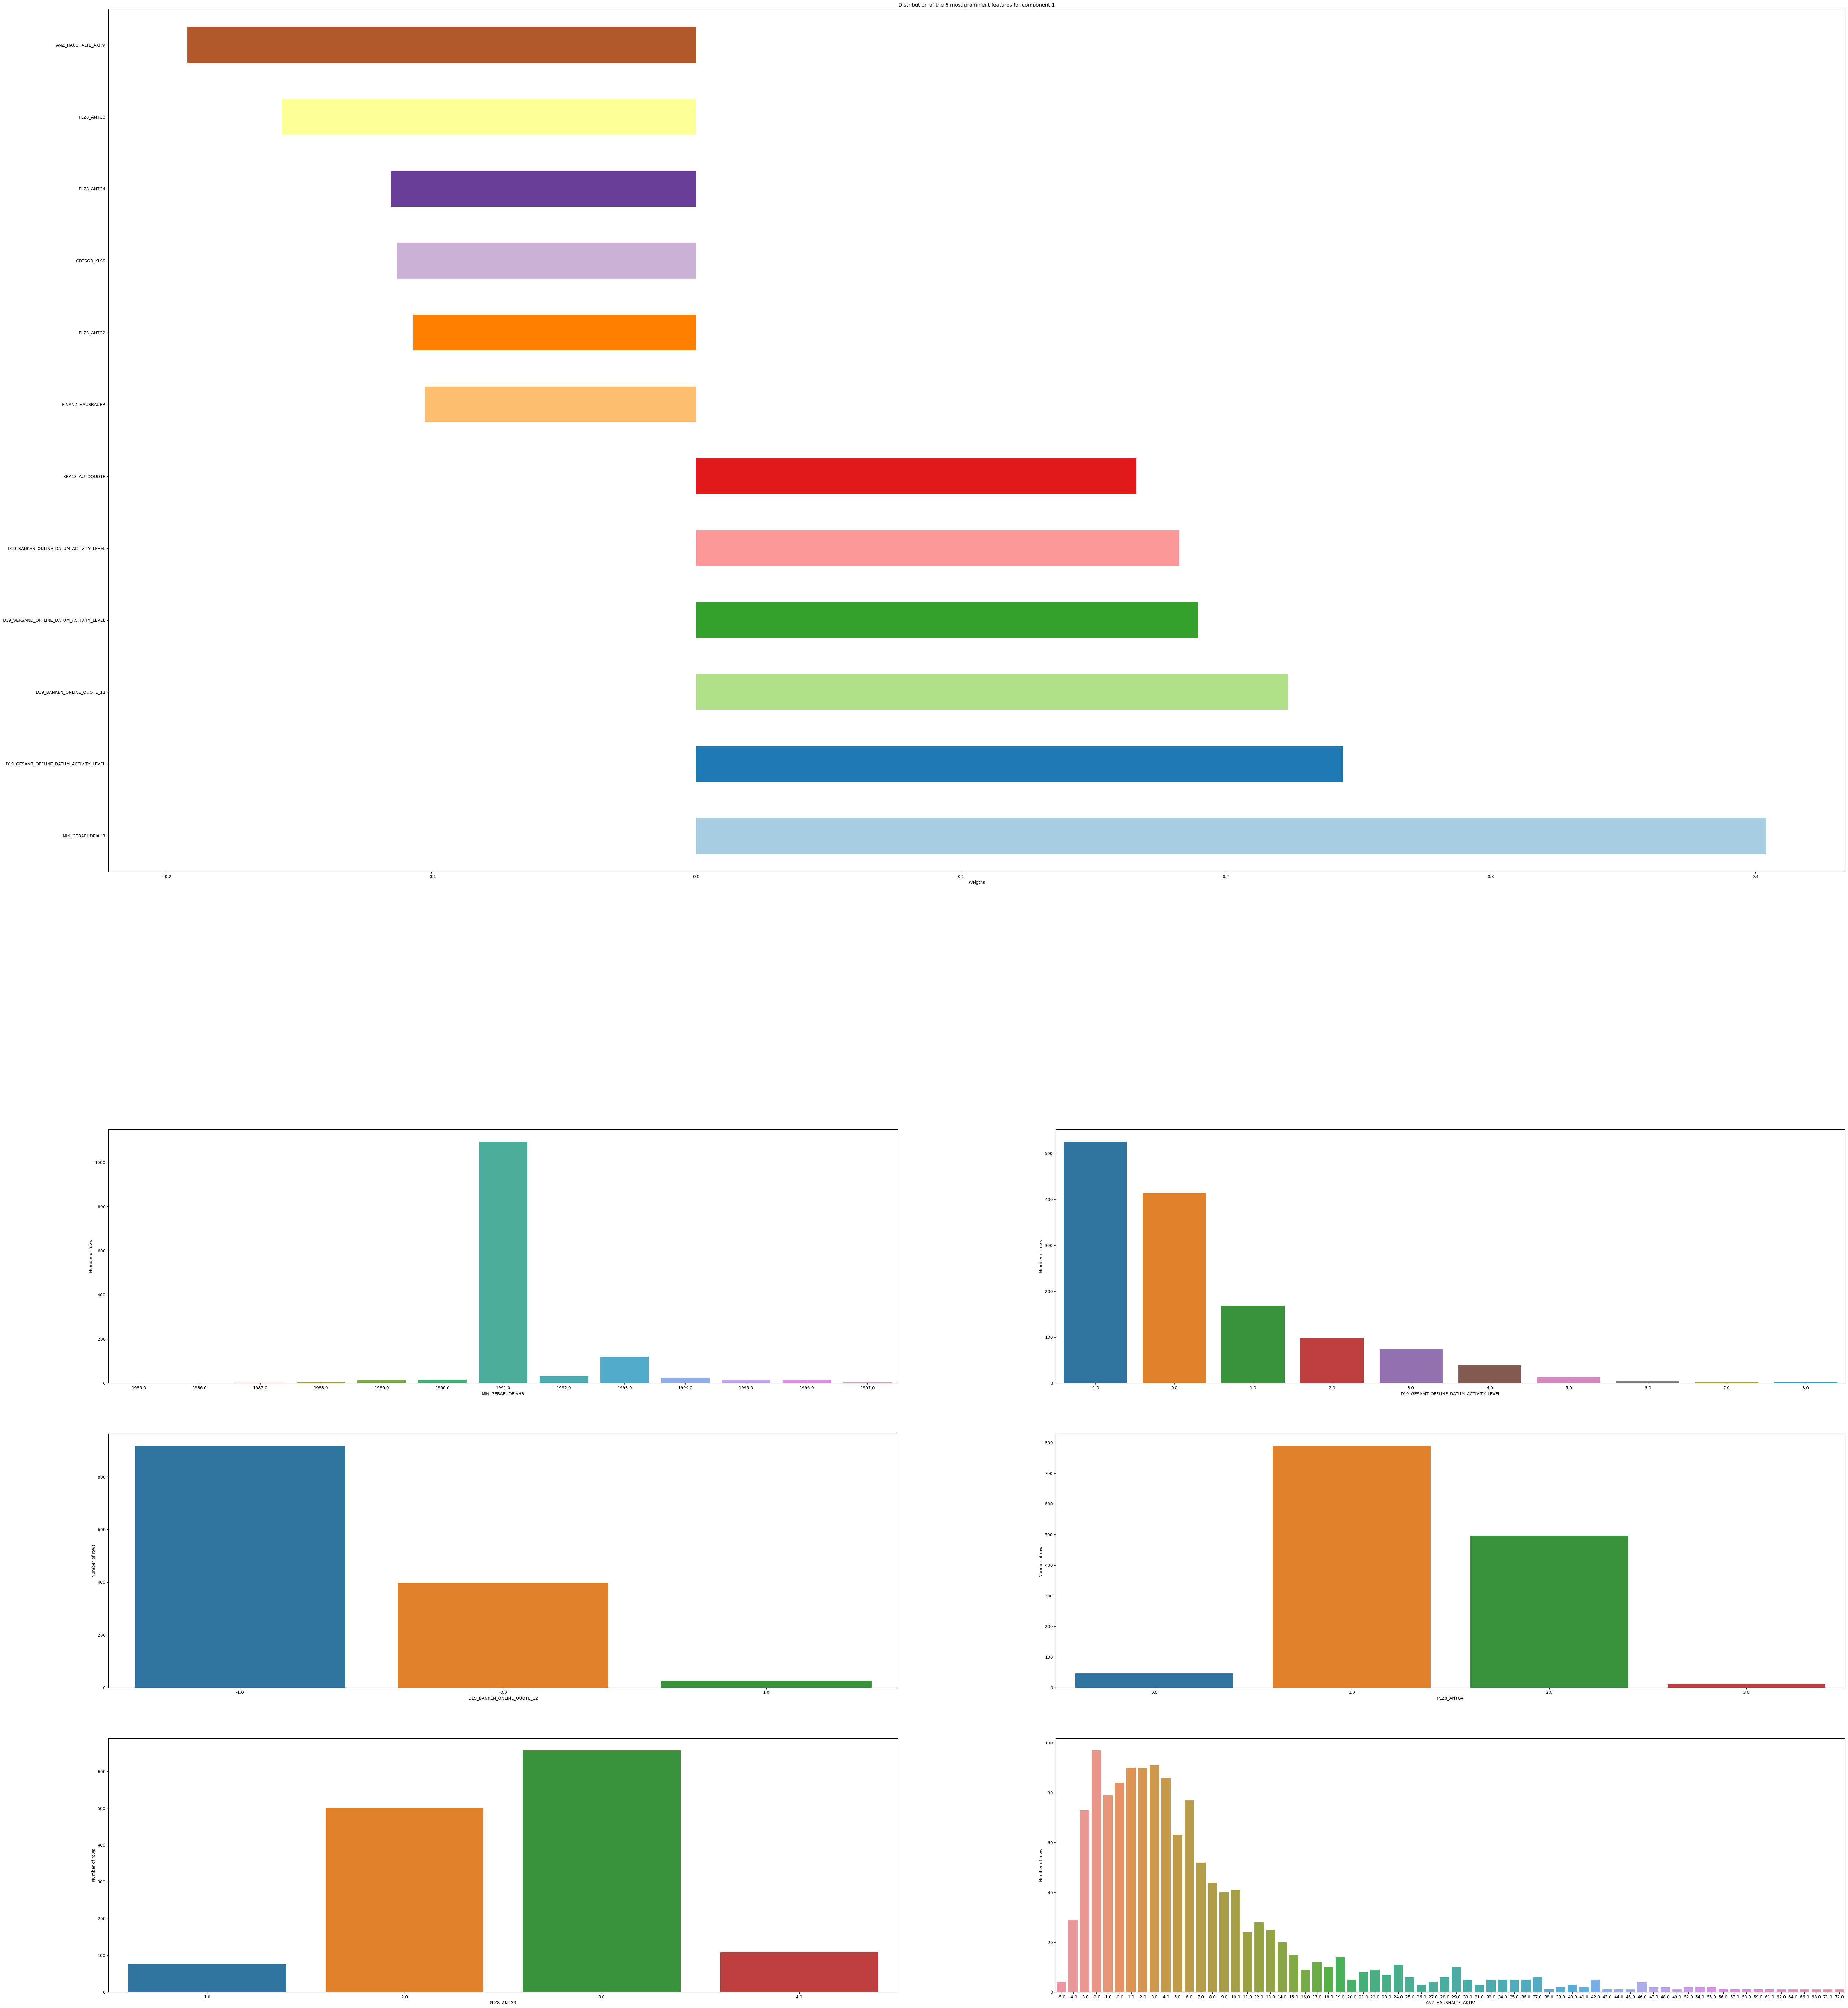

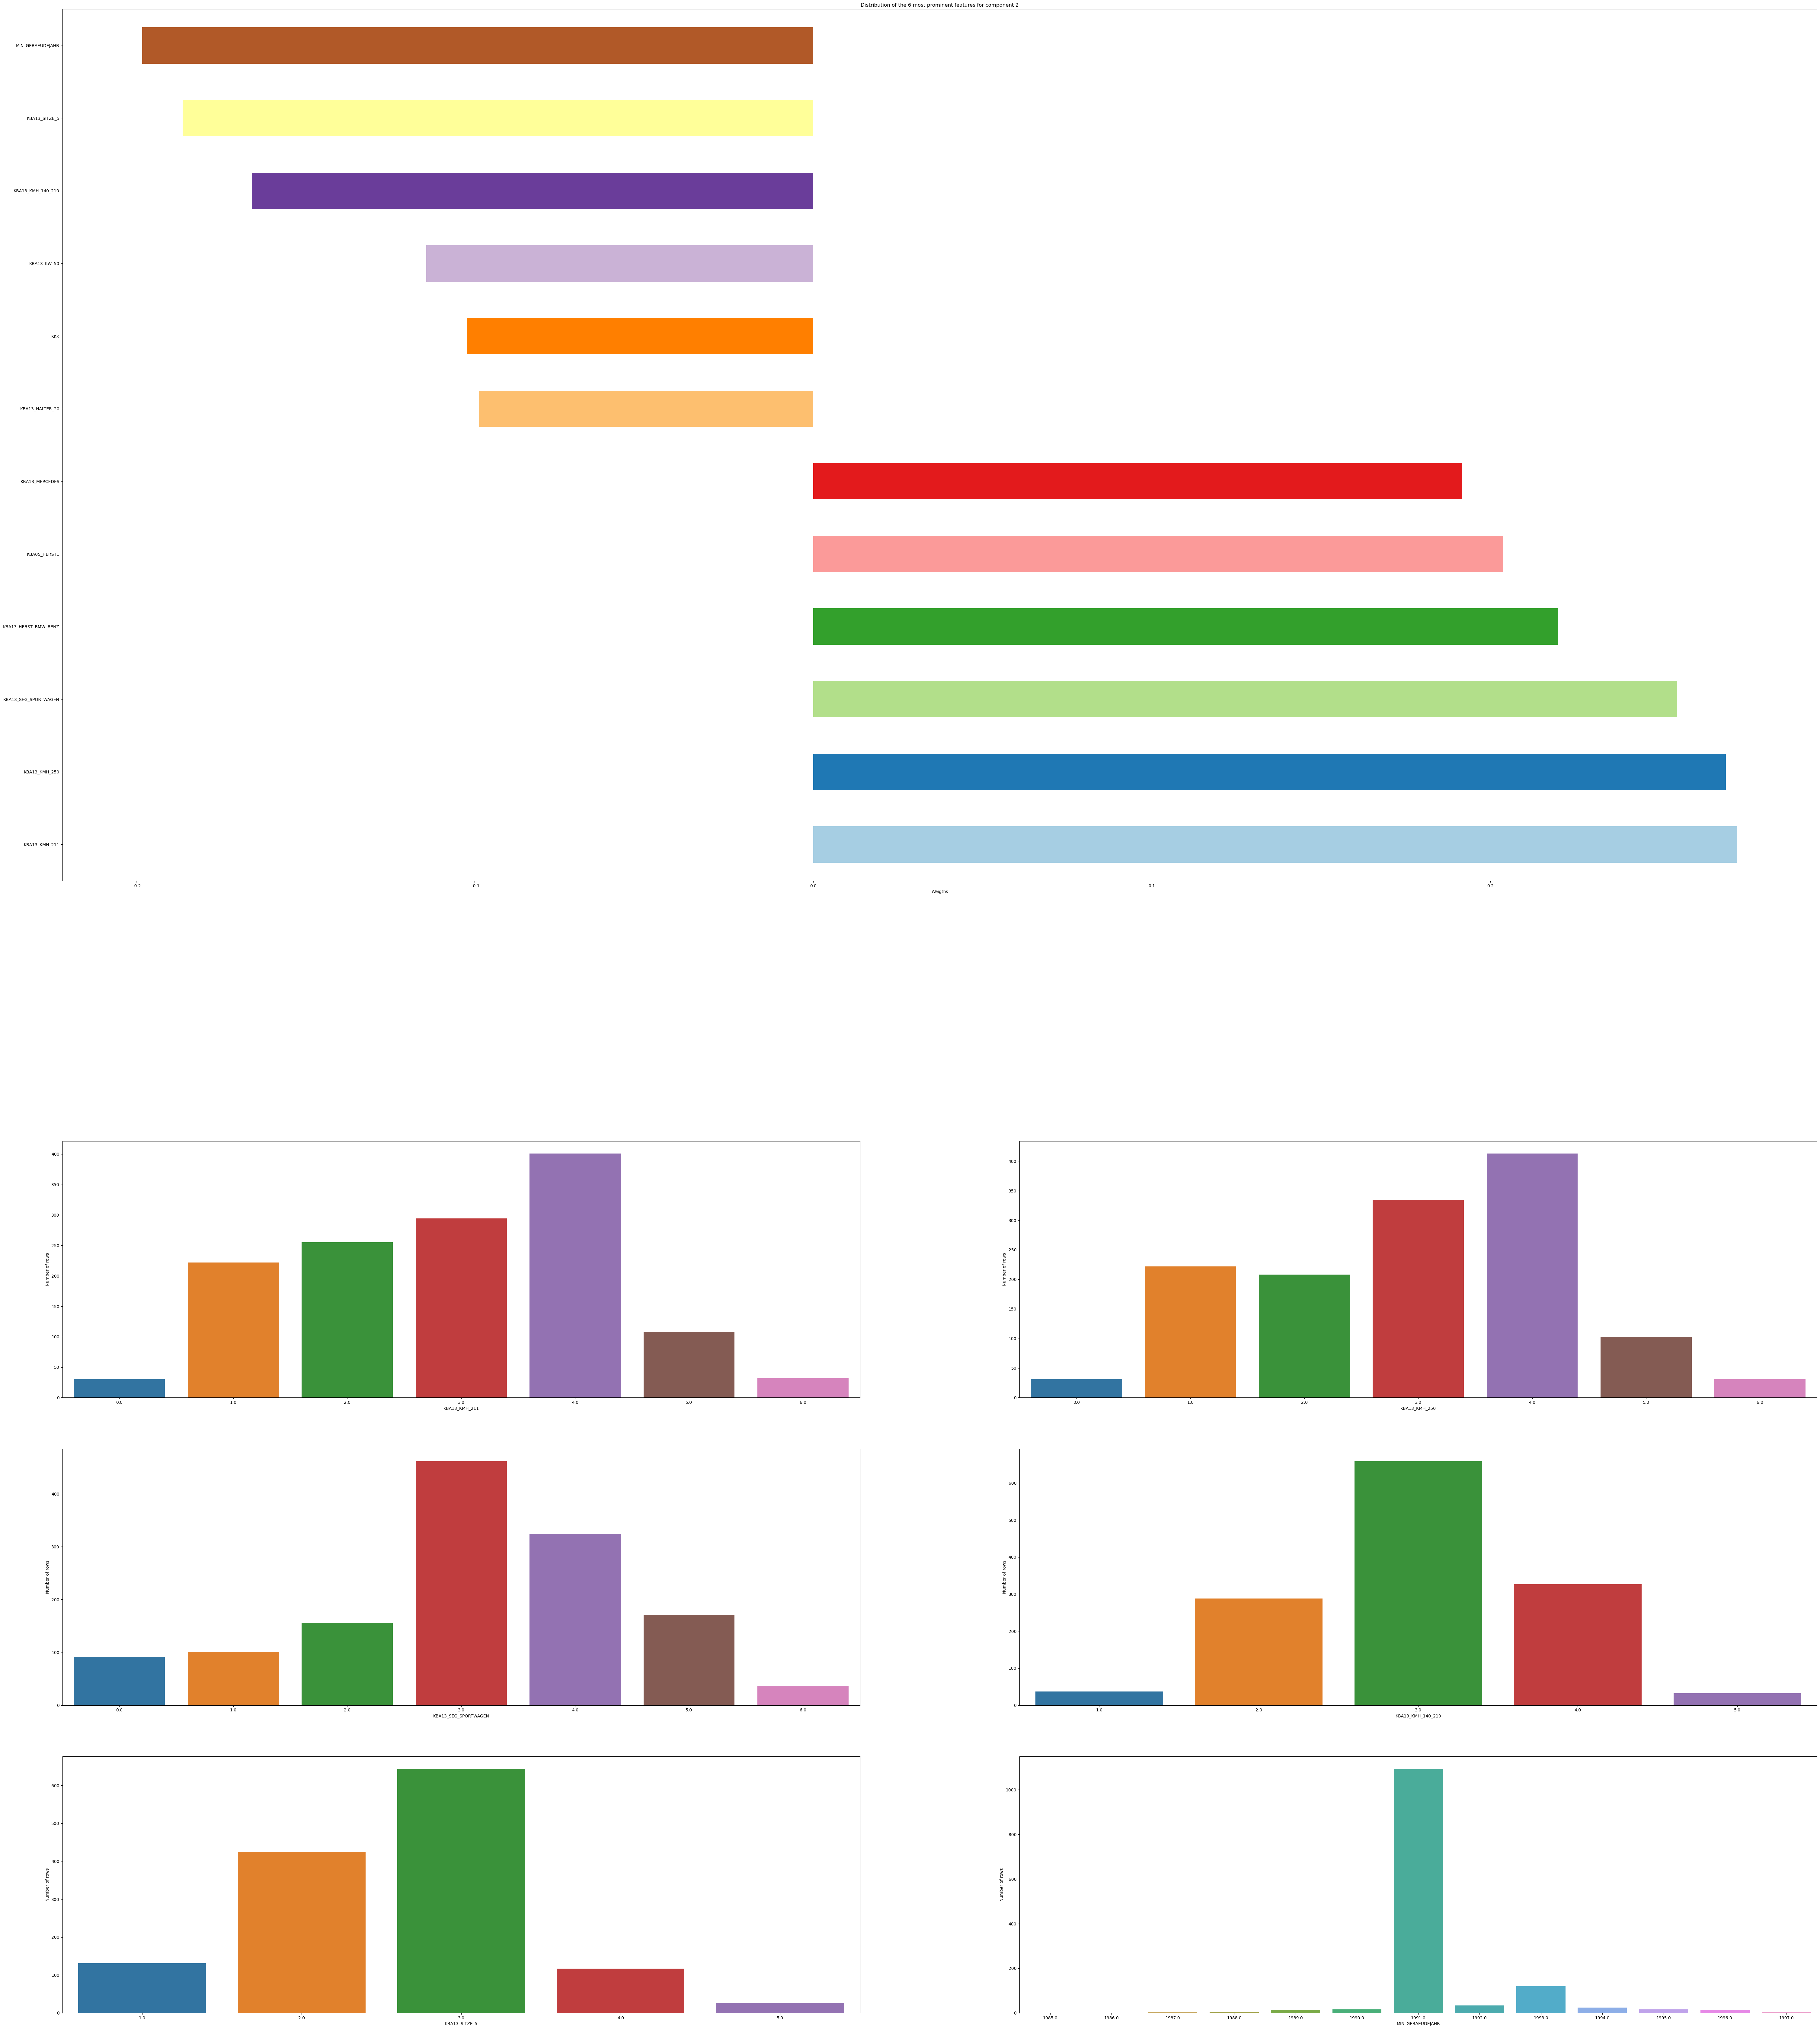

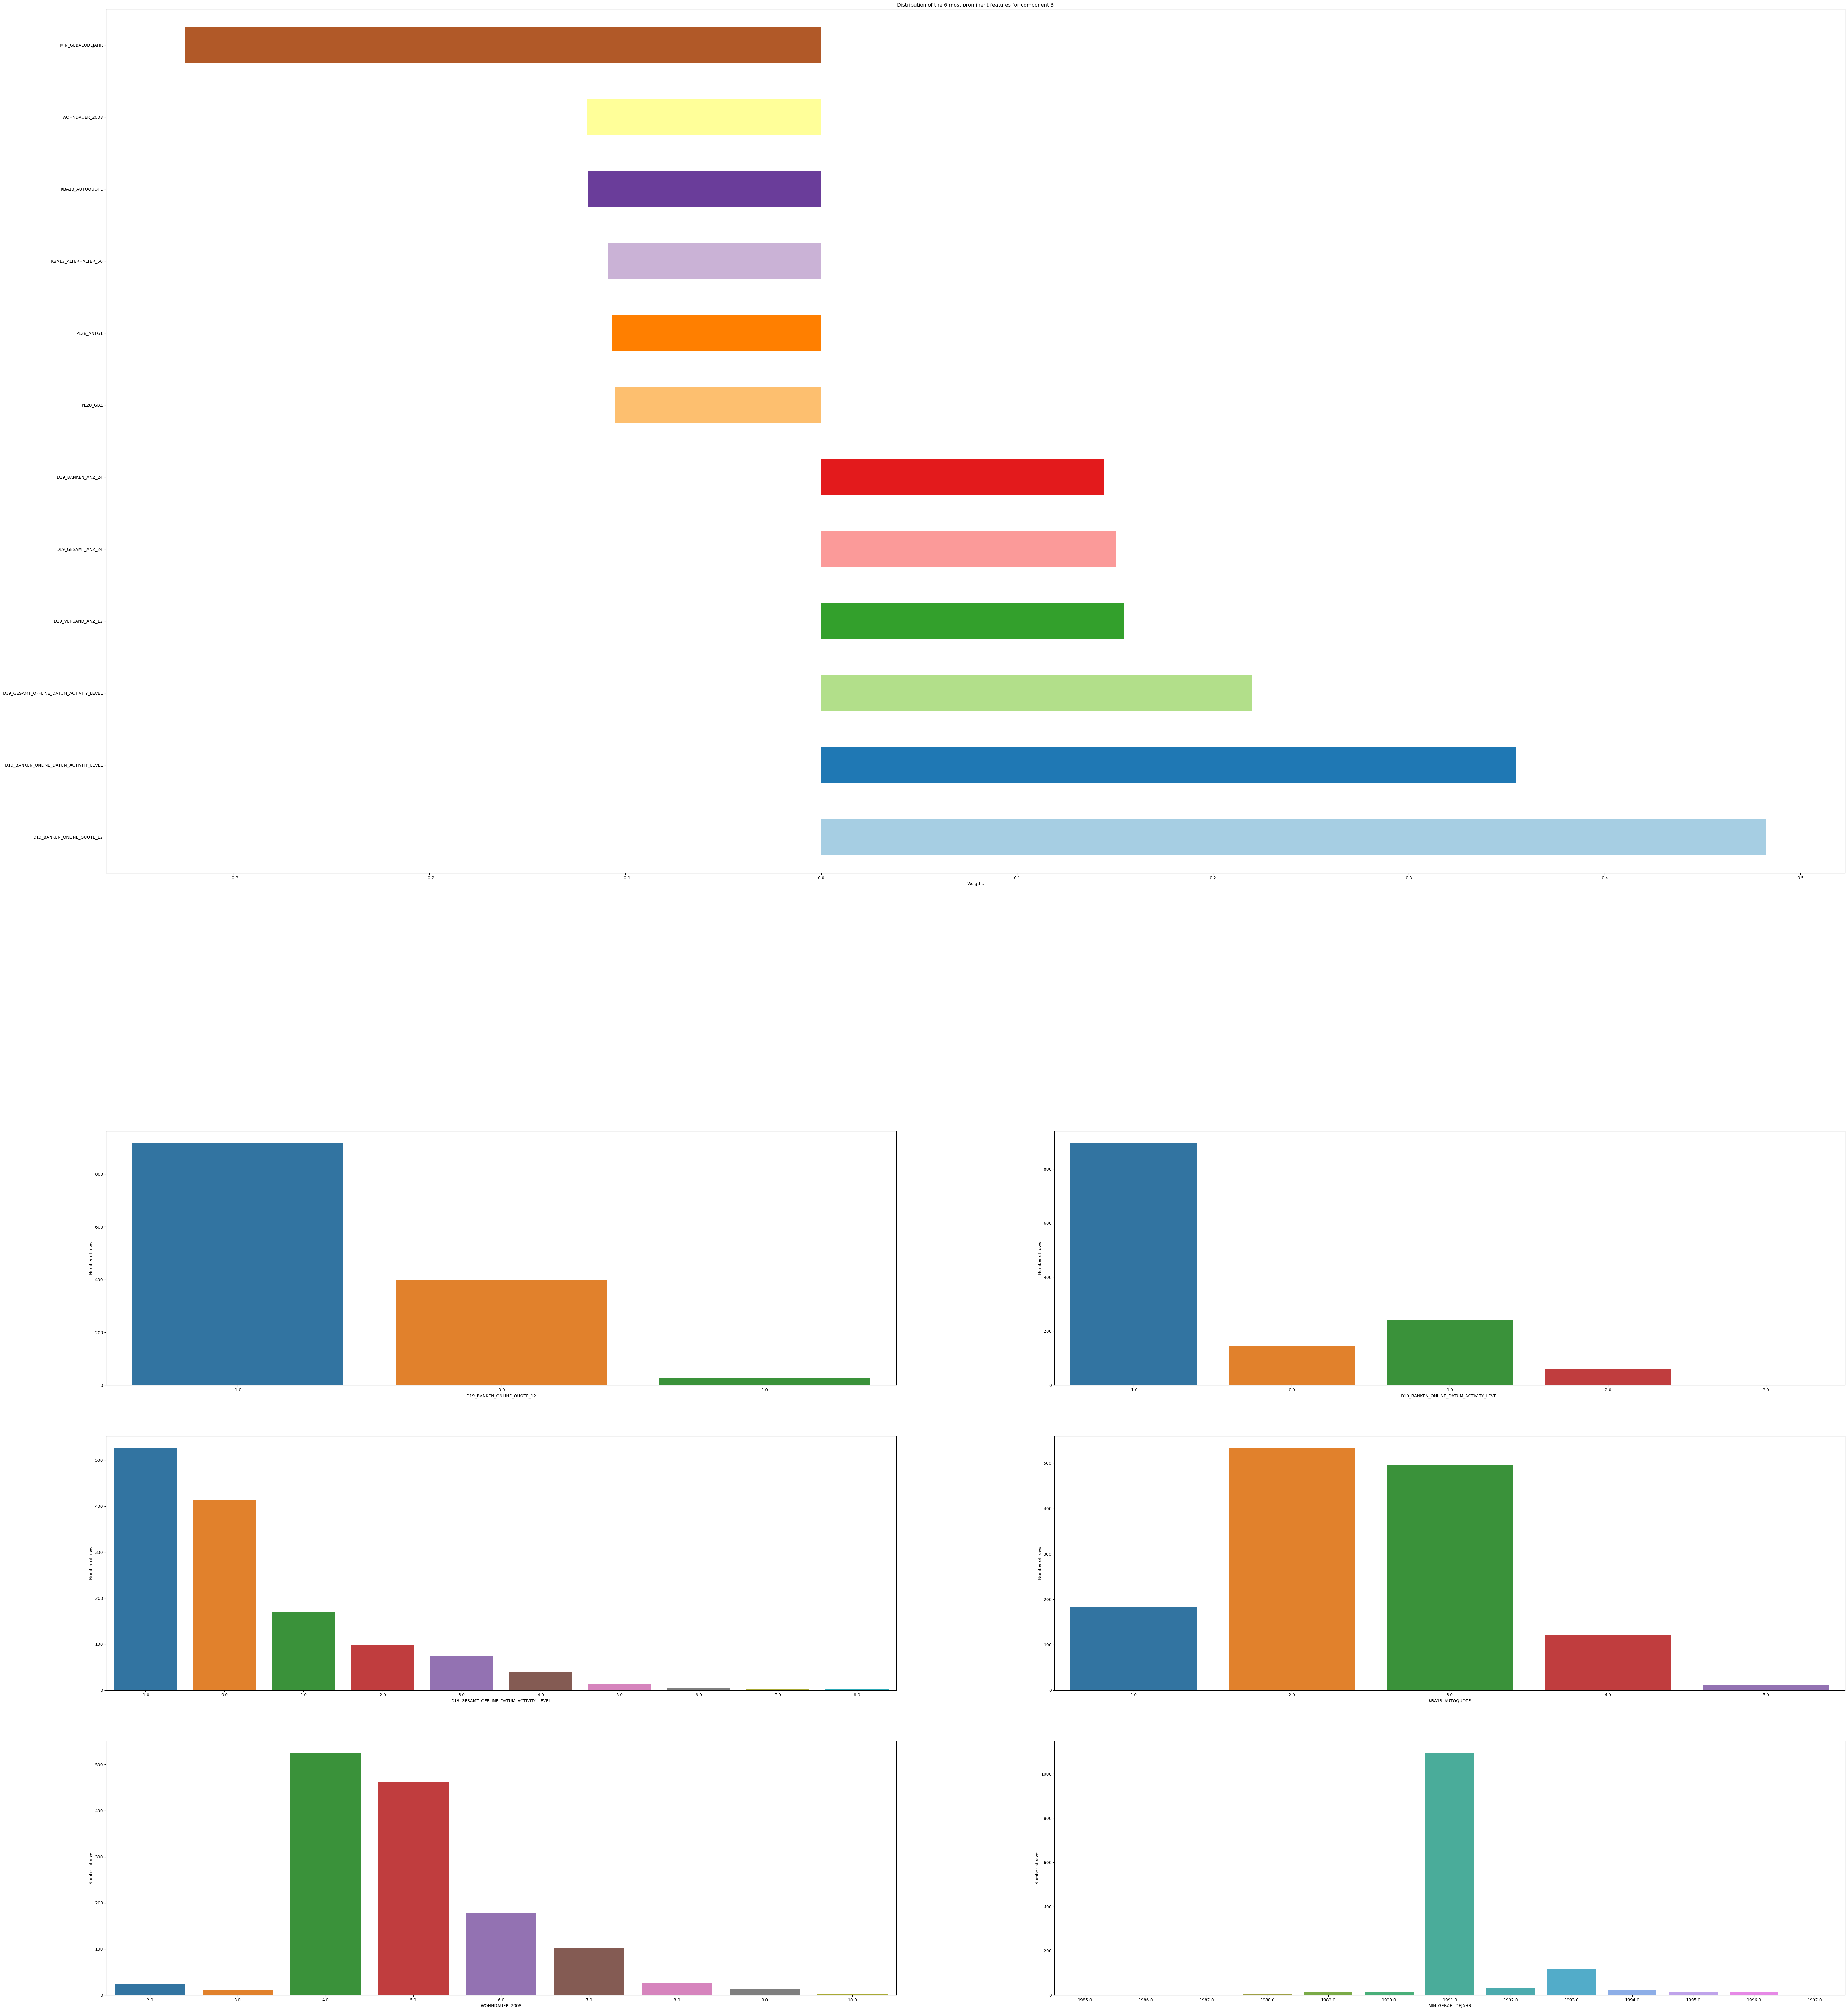

In [28]:
analyze_under_or_over_rep_cust_clusters(full_pl['reducer'].df_reducer, df_cleaned, X_orig, 13, cust_labels)

What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?

Let's now analyze the first 3 principal components together with the plot distributions of the features associated with the weights for the cluster_id=7

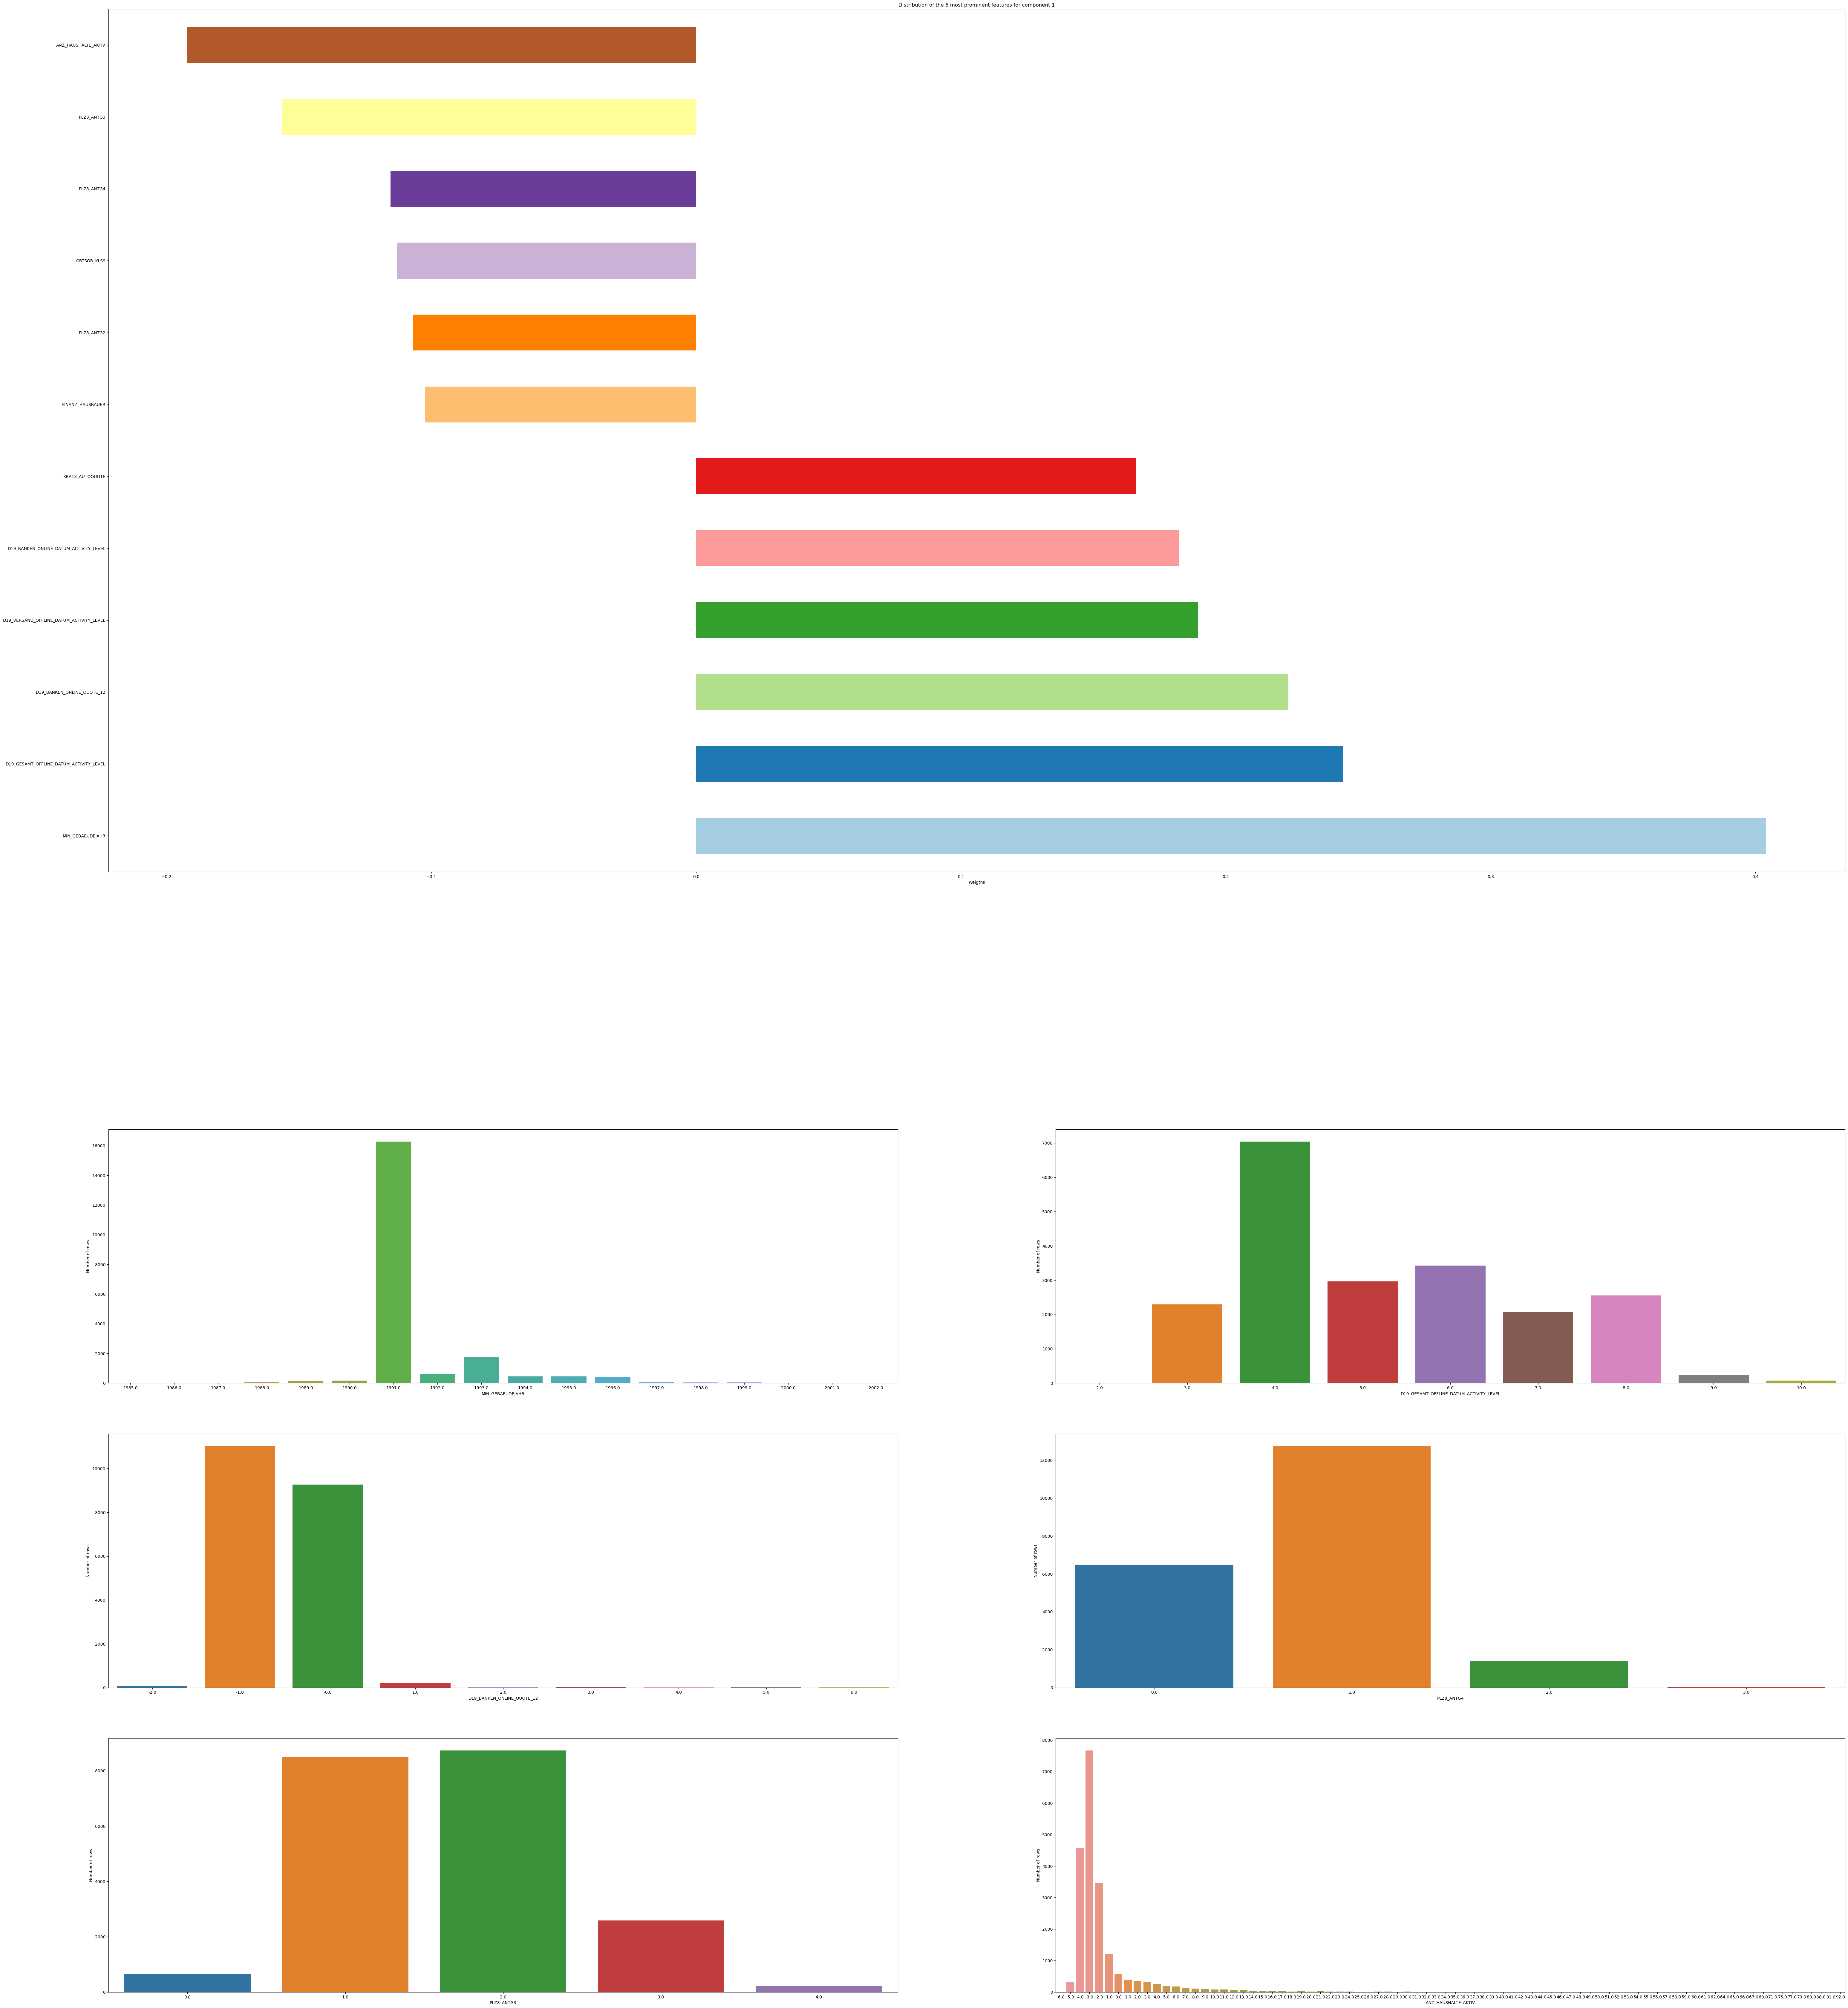

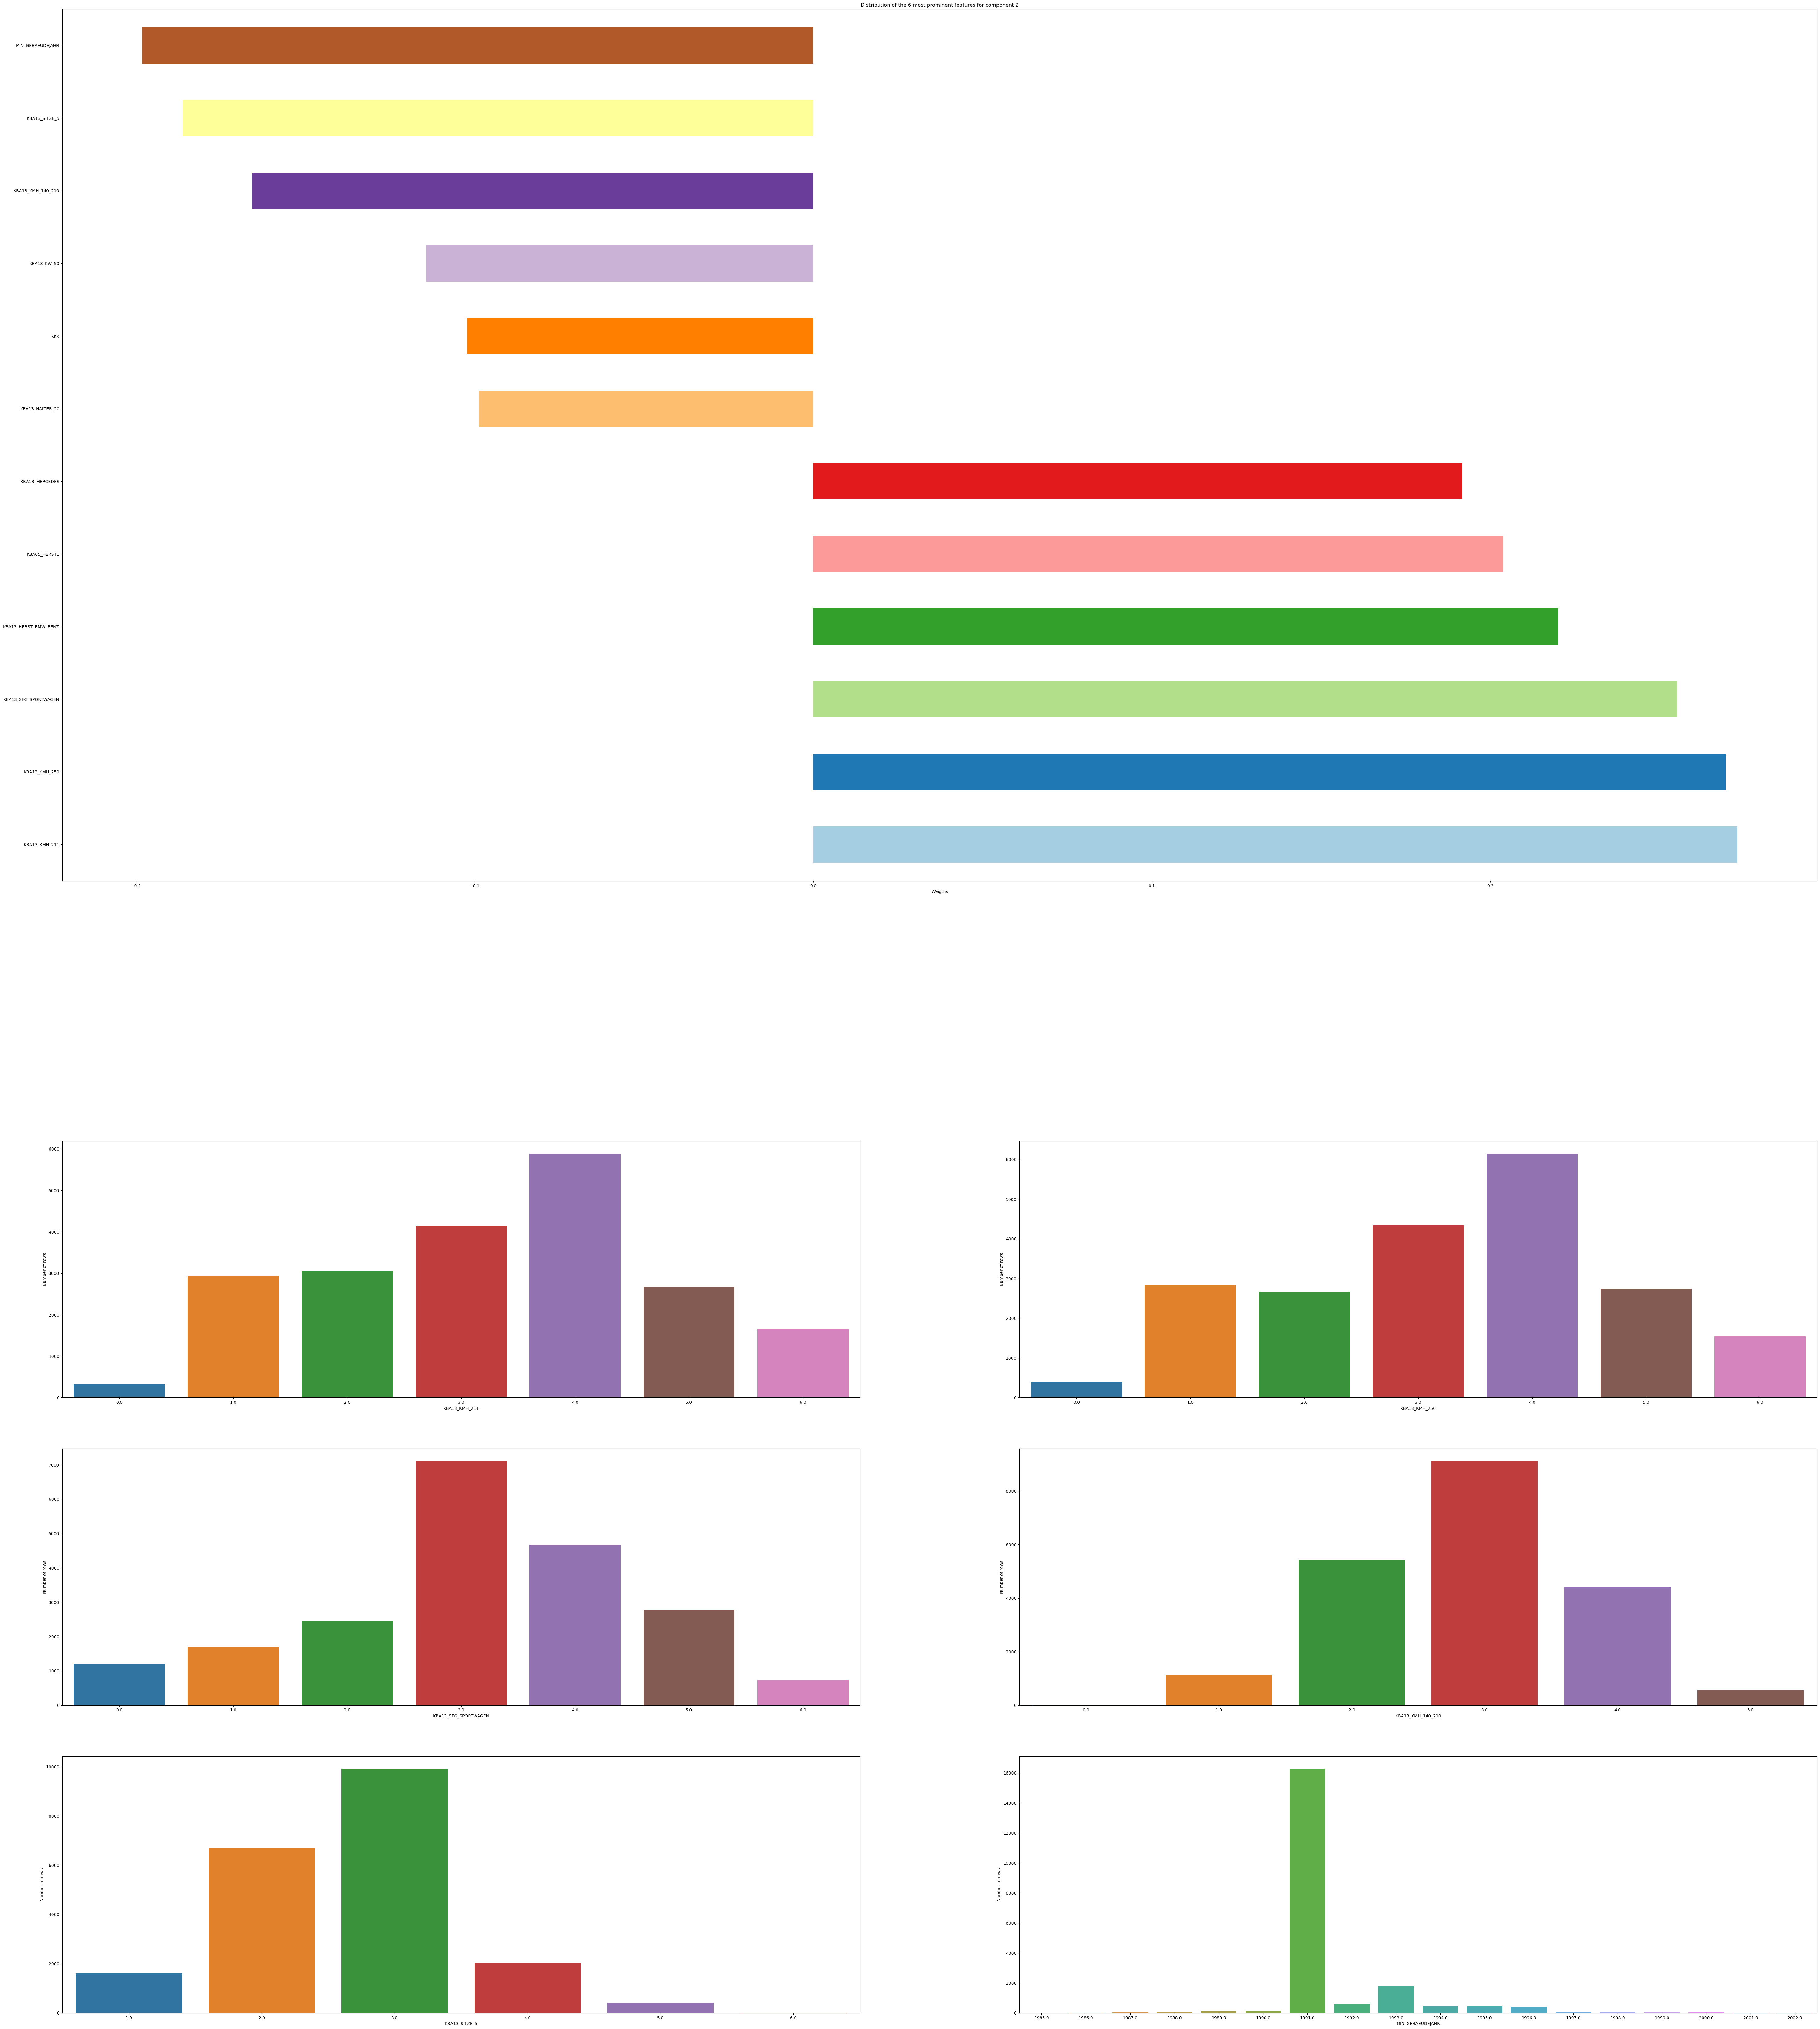

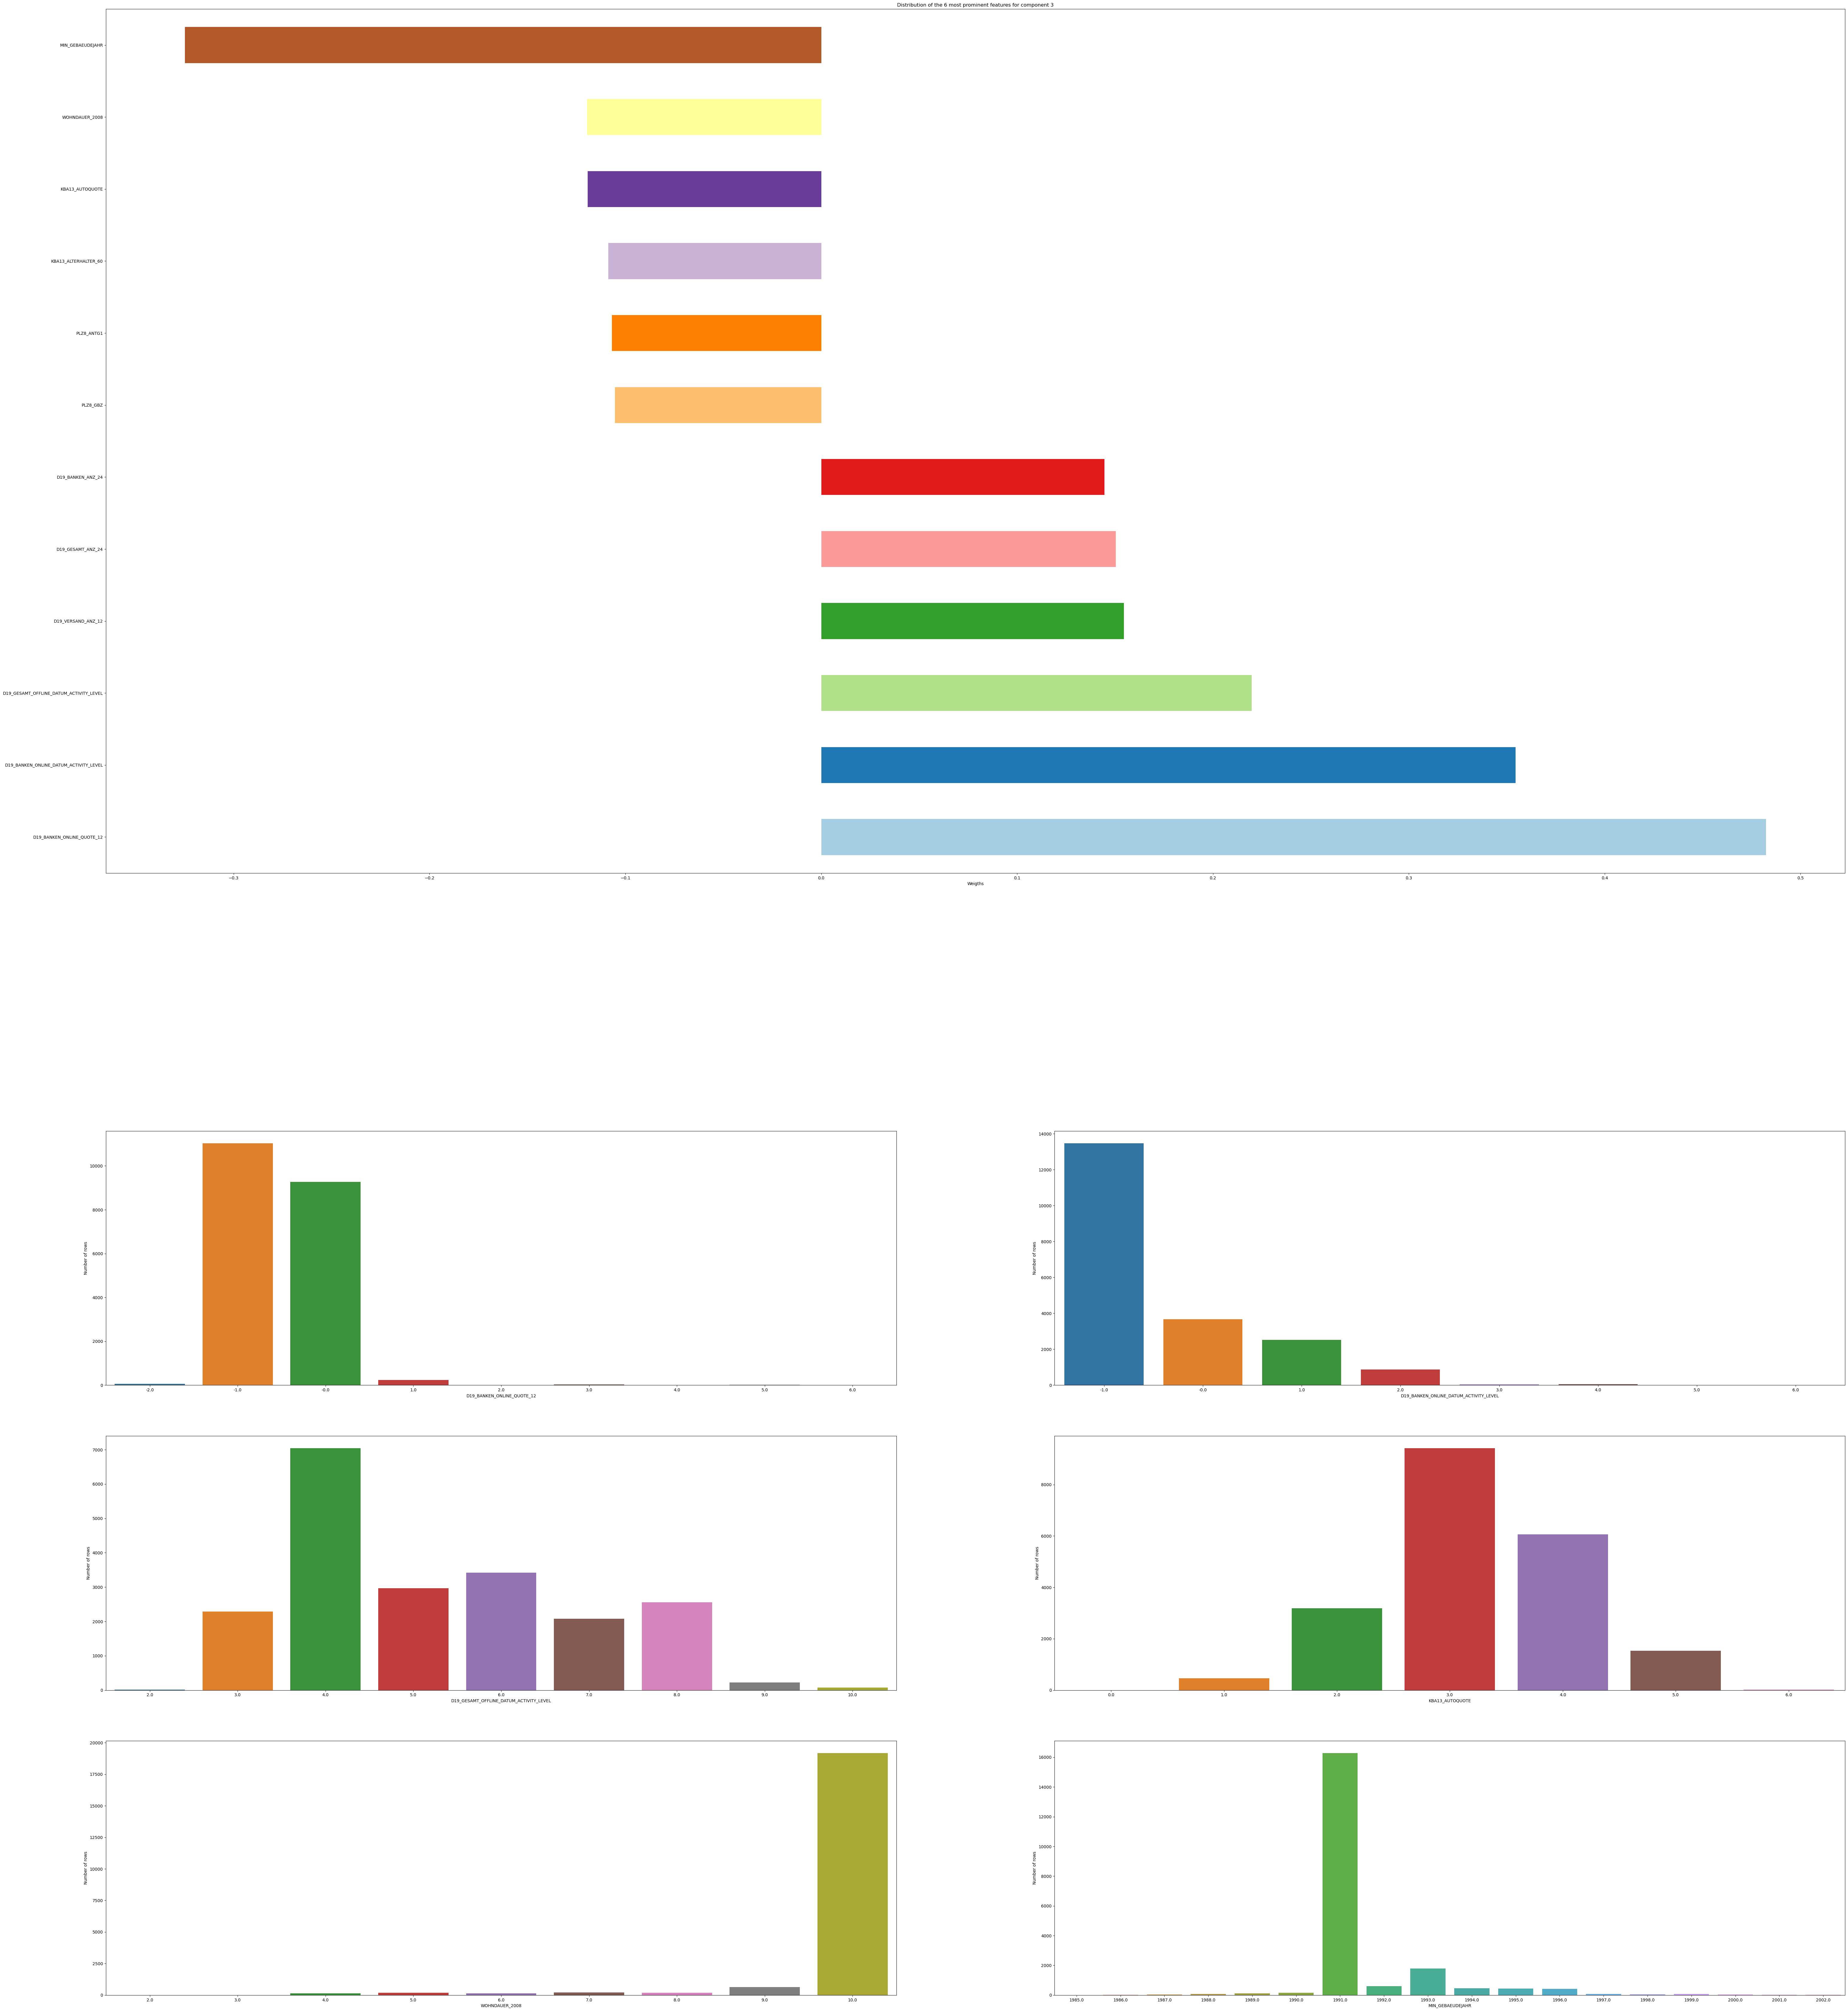

In [29]:
analyze_under_or_over_rep_cust_clusters(full_pl['reducer'].df_reducer, df_cleaned, X_orig, 7, cust_labels)

The resuts of these plots are naalyzed in detail at this [post](https://medium.com/@francesc.lopezr/defining-customer-clusters-and-improving-customer-response-2b6c64e2727e) 